In [1]:
!which pip3

/home/mgross/anaconda3/envs/contrast-net/bin/pip3


In [2]:
! nvidia-smi

Thu Jan 29 04:41:05 2026       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 8000                Off | 00000000:17:00.0 Off |                  Off |
| 33%   29C    P8              23W / 260W |   2118MiB / 49152MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import IPython
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import pandas as pd
import pytorch_lightning
from monai.visualize import img2tensorboard
import torch
import time
import sklearn

from torch.utils.data import DataLoader

import monai
from monai.transforms import \
    Compose, LoadImaged, AddChanneld, Orientationd, \
    NormalizeIntensityd, ScaleIntensityRangePercentilesd, \
    SpatialPadd, Spacingd, \
    RandCropByPosNegLabeld, ToTensord,  \
    DataStatsd, AsDiscrete, KeepLargestConnectedComponent, RandFlipd
#LoadNiftid


from monai.data import list_data_collate
from monai.networks.layers import Norm

# from monai.metrics import compute_meandice
from monai.transforms import KeepLargestConnectedComponent

from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm





monai.config.print_config()

MONAI version: 0.7.0
Numpy version: 1.20.3
Pytorch version: 1.8.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: bfa054b9c3064628a21f4c35bbe3132964e91f43

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.3.1
Tensorboard version: 2.6.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.2
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.4
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
print('CUDA available: ', torch.cuda.is_available())

n_gpus = torch.cuda.device_count()
for i in range(n_gpus):
    print('GPU %d: %s' % (i, torch.cuda.get_device_name(i)))


CUDA available:  True
GPU 0: Quadro RTX 8000


## Load the Data

In [5]:
INPUT_PATH = '../../ContrastNets.xlsx'
df = pd.read_excel(INPUT_PATH, index_col=False)
df.rename(columns= {'PV': 'IMAGE'}, inplace = True)

In [6]:
df_train, df_val, df_test = \
              np.split(df.sample(frac=1, random_state=50), 
                       [int(.7*len(df)), int(.85*len(df))])


df_train['DATA_SPLIT'] = 'Train'
df_val['DATA_SPLIT'] = 'Val'
df_test['DATA_SPLIT'] = 'Test'


df = pd.concat([df_train, df_val, df_test])

In [7]:
# Convert DF to dictionary
train_data_dict = df_train.to_dict('records')
val_data_dict = df_val.to_dict('records')
test_data_dict = df_test.to_dict('records')

## Setup Input Transformations

In [8]:
SPACING = (2.0,2.0,2.0)
#PATCH_SIZE = (96,96,16)
PATCH_SIZE = (64,64,32)




train_transforms = Compose([
    LoadImaged(keys=['IMAGE', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['IMAGE', 'SEGM']),
    Orientationd(keys=['IMAGE','SEGM'], axcodes='RAS'),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('train_image','train_segm')),
    Spacingd(keys=['IMAGE', 'SEGM'], pixdim=SPACING, mode=('bilinear', 'nearest'), padding_mode=('reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
    SpatialPadd(keys=['IMAGE', 'SEGM'], spatial_size=PATCH_SIZE, mode=('reflect','reflect'), ),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('train_image','train_segm')),
    # randomly crop out patch samples from big image based on pos / neg ratio
    # the image centers of negative samples must be in valid image area
    RandCropByPosNegLabeld(keys=['IMAGE', 'SEGM'], label_key='SEGM', spatial_size=PATCH_SIZE, pos=3, neg=1, num_samples=2),
    RandFlipd(keys=['IMAGE', 'SEGM'], prob=0.5, spatial_axis=0),
    ToTensord(keys=['IMAGE', 'SEGM'])
])

val_transforms = Compose([
     LoadImaged(keys=['IMAGE', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['IMAGE', 'SEGM']),
    Orientationd(keys=['IMAGE','SEGM'], axcodes='RAS'),
    Spacingd(keys=['IMAGE', 'SEGM'], pixdim=SPACING, mode=('bilinear', 'nearest'), padding_mode=('reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),    
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['IMAGE', 'SEGM'])
])

test_transforms = Compose([
    LoadImaged(keys=['IMAGE', 'SEGM'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['IMAGE', 'SEGM']),
    Orientationd(keys=['IMAGE','SEGM'], axcodes='RAS'),
    Spacingd(keys=['IMAGE', 'SEGM'], pixdim=SPACING, mode=('bilinear', 'nearest'), padding_mode=('reflection','reflection')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['IMAGE', 'SEGM'])
])


inference_transforms = Compose([
     LoadImaged(keys=['IMAGE'], reader='NibabelReader', as_closest_canonical=True),
    AddChanneld(keys=['IMAGE']),
    Orientationd(keys=['IMAGE'], axcodes='RAS'),
    Spacingd(keys=['IMAGE'], pixdim=SPACING, mode=('bilinear'), padding_mode=('reflection')),
    ScaleIntensityRangePercentilesd(keys=['IMAGE'], lower=25, upper=75, b_min=-0.5, b_max=0.5, clip=False),
#     DataStatsd(keys=['IMAGE','SEGM'], prefix=('val_image','val_segm')),
    ToTensord(keys=['IMAGE'])
])



## Create a Persistent Data Cache for Training and Validation Data

In [9]:
CACHE_PATH = '/tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-Net/monai_cache'


In [10]:
train_ds = monai.data.PersistentDataset(
    data=train_data_dict, transform=train_transforms, cache_dir=CACHE_PATH
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, collate_fn=list_data_collate)

In [11]:
val_ds = monai.data.PersistentDataset(
    data=val_data_dict, transform=val_transforms, cache_dir=CACHE_PATH
)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate)

In [12]:
test_ds = monai.data.PersistentDataset(
    data=test_data_dict, transform=test_transforms, cache_dir=CACHE_PATH
)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

## Check Input Data

torch.Size([2, 1, 64, 64, 32])
image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 1.0757936239242554


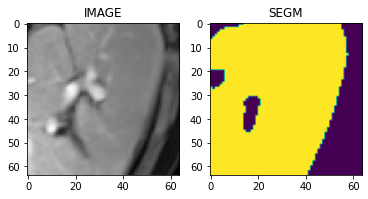

image shape: torch.Size([64, 64, 32]), label shape: torch.Size([64, 64, 32])
image mean: 0.5108928680419922


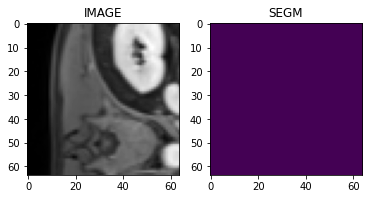

In [13]:
check_ds = monai.data.Dataset(data=train_data_dict[:10], transform=train_transforms)
#check_ds = monai.data.Dataset(data=val_data_dict[:1], transform=val_transforms)
#check_ds = monai.data.Dataset(data=test_data_dict[:1], transform=test_transforms)

check_loader = DataLoader(check_ds, batch_size=1, num_workers=0, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['IMAGE'].shape)

num_display = 10
if check_data['IMAGE'].shape[0] < num_display:
    num_display = check_data['IMAGE'].shape[0]

for i in range(num_display):
    image, label = (check_data['IMAGE'][i][0], check_data['SEGM'][i][0])
    print('image shape: {}, label shape: {}'.format(image.shape, label.shape))
    print('image mean: {}'.format(np.mean(image.numpy())))

    slice_num = image.shape[2]//2
    
    plt.figure('check', (6, 3))
    plt.subplot(1, 2, 1)
    plt.title('IMAGE')
    plt.imshow(image[:,:,slice_num], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('SEGM')
    plt.imshow(label[:,:,slice_num])
    plt.show()

## Create Segmentation Model (U-net)

In [14]:
class MRILiverSegmentation(pytorch_lightning.LightningModule):

    def __init__(self, dropout_rate = 0.0):
        super().__init__()
        
        self._model = monai.networks.nets.UNet(
            dimensions=3, 
            in_channels=1, 
            out_channels=2, 
            channels=(16, 32, 64, 128),
            #channels=(64, 128, 256, 512),
            strides=(2, 2, 2), 
            num_res_units=2, 
            norm=Norm.BATCH,
            dropout = dropout_rate,
        )

    
        self.loss_function = monai.losses.DiceLoss(include_background=False, to_onehot_y=True, softmax=True)
        self.one_hot_transform = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
        self.val_metric = DiceMetric(include_background=False)

        self.best_val_dice = None
        self.best_val_epoch = None
        
        
    def forward(self, x):
        return self._model(x)

    
    def prepare_data(self):
        # set deterministic training for reproducibility
        set_determinism(seed=0)
    
    
    def training_step(self, batch, batch_idx):
        images, labels = batch["IMAGE"], batch["SEGM"]
        #print(batch['ACCESSION_ID'])
        
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        return {"loss": loss}
    
    
    def training_epoch_end(self, outputs):
        # Only add the graph at the first epoch
        if self.current_epoch==1:
            #sample_input = torch.rand((1,1,96,96,16))
            sample_input = torch.rand((1,1,64,64,32))
            self.logger.experiment.add_graph(
                MRILiverSegmentation(), 
                [sample_input])
        
        # Calculate the average loss
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Train/Loss', avg_loss, self.current_epoch)
    
    

    def validation_step(self, batch, batch_idx):
        images = batch["IMAGE"]
        labels = batch["SEGM"]

        #roi_size = (256, 256, 48)
        roi_size = (224, 224, 128)
        sw_batch_size = 4
        outputs = sliding_window_inference(images, roi_size, sw_batch_size, self.forward)

        loss = self.loss_function(outputs, labels)

#         one_hot = monai.networks.utils.one_hot(labels, num_classes=3)
        argmax = torch.argmax(outputs, dim=1, keepdim=True)
        val_dice = self.val_metric(
            self.one_hot_transform(argmax), 
            self.one_hot_transform(labels)
        )
                
        if batch_idx<1:
            img2tensorboard.plot_2d_or_3d_image(data=images, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Input')
            img2tensorboard.plot_2d_or_3d_image(data=argmax, 
                            step=self.current_epoch, 
                            writer=self.logger.experiment,
                            tag='Validation/Output')

        return {"val_loss": loss, "val_dice": val_dice}
    
    def validation_epoch_end(self, outputs):
        # Calculate the average loss
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_dice = torch.stack([x['val_dice'][0] for x in outputs]).mean()
        # Logging at the end of every epoch
        self.logger.experiment.add_scalar('Val/Loss', avg_loss, self.current_epoch)
        self.logger.experiment.add_scalar('Val/Dice', avg_dice, self.current_epoch)
        
        self.log('val_loss', avg_loss)
        self.log('val_dice', avg_dice)

    
    def configure_optimizers(self):
        return torch.optim.Adam(self._model.parameters(), lr=1e-4)
    
    

In [24]:
from torchinfo import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MRILiverSegmentation()
#summary(model.to(device), [1,1,96,96,16])
summary(model.to(device), [1,1,64,64,32])

Layer (type:depth-idx)                                                           Output Shape              Param #
MRILiverSegmentation                                                             --                        --
├─UNet: 1-1                                                                      [1, 2, 64, 64, 32]        --
│    └─Sequential: 2-1                                                           [1, 2, 64, 64, 32]        --
│    │    └─ResidualUnit: 3-1                                                    [1, 16, 32, 32, 16]       7,890
│    │    └─SkipConnection: 3-2                                                  [1, 32, 32, 32, 16]       1,178,186
│    │    └─Sequential: 3-3                                                      [1, 2, 64, 64, 32]        1,845
Total params: 1,187,921
Trainable params: 1,187,921
Non-trainable params: 0
Total mult-adds (G): 1.67
Input size (MB): 0.52
Forward/backward pass size (MB): 45.22
Params size (MB): 4.75
Estimated Total Size (MB):

## Model Training

In [25]:
MODEL_ROOT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-Net'

In [26]:
# initialise the LightningModule
model = MRILiverSegmentation(dropout_rate=0.3)

# set up loggers and checkpoints
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
    save_dir=os.path.join(MODEL_ROOT_PATH,'saved_model','logs')
)

lr_monitor = pytorch_lightning.callbacks.LearningRateMonitor(logging_interval='epoch')

checkpoint_callback = pytorch_lightning.callbacks.ModelCheckpoint(
    dirpath=os.path.join(MODEL_ROOT_PATH,'saved_model'),
    filename="MRILiverSegmentation-{epoch:04d}-{val_loss:.2f}",
    monitor='val_loss',
    save_last=True,
    save_on_train_epoch_end=True,
    save_top_k=2,
    mode='min'
)

# check for last checkpoint
resume_checkpoint = None
if os.path.exists(os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')):
    resume_checkpoint = os.path.join(MODEL_ROOT_PATH,'saved_model','last.ckpt')

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[0],
    max_epochs=2000,
    logger=tb_logger,
    callbacks=[lr_monitor,checkpoint_callback],
    num_sanity_val_steps=1,
    check_val_every_n_epoch=20,
    resume_from_checkpoint=resume_checkpoint
)

# train
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:45: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:730: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1893: LightningDeprecationWarning: `trainer.resume_from_checkpoint` is deprecated in v1.5 and will be removed in v1.7. Specify the fit ch

Validation sanity check: 0it [00:00, ?it/s]

/home/mgross/anaconda3/envs/contrast-net/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 7. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


## Model Testing

In [28]:
model_path = os.path.join(MODEL_ROOT_PATH,'saved_model','MRILiverSegmentation-epoch=1500-val_loss=0.06.ckpt')

In [29]:
model = MRILiverSegmentation.load_from_checkpoint(model_path)
# model.load_from_checkpoint(model_path)
model.eval()
device = torch.device("cuda:0")
model.to(device)

MRILiverSegmentation(
  (_model): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
          (unit1): Convolution(
            (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (adn): ADN(
              (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
        )
        (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      )
      (1): SkipConnection(
        

In [31]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import torch
import time


from monai.transforms import KeepLargestConnectedComponent
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm
from monai.data import decollate_batch




def compute_evaluation_metrics(y_pred, y, keep=False):
    
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    hd = monai.metrics.HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95, get_not_nans=False)
    mad = monai.metrics.SurfaceDistanceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep_largest = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    dice_list = list()
    hd_list = list()
    mad_list = list()
    for y_pred_i, y_i in decollate_batch((y_pred, y)):
        print(y_pred_i.shape)
        print(y_i.shape)
        if keep:
            #dice(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #hd(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #mad(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            y_pred_i_proc=one_hot(keep_largest(argmax(y_pred_i)))
        else:
                
            # Calculate Dice on the raw output
            #dice(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #hd(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #mad(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            y_pred_i_proc = one_hot(argmax(y_pred_i))
        y_pred_i_proc = monai.transforms.AddChannel()(y_pred_i_proc)
        y_i_proc = monai.transforms.AddChannel()(one_hot(y_i))
        print(y_pred_i_proc.shape)
            
        #dice(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #hd(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #mad(y_pred=y_pred_i_proc, y=one_hot(y_i))
            
        dice(y_pred=y_pred_i_proc, y=y_i_proc)
        hd(y_pred=y_pred_i_proc, y=y_i_proc)
        mad(y_pred=y_pred_i_proc, y=y_i_proc)
        
        dice_value = dice.aggregate().item()
        hd_value = hd.aggregate().item()
        mad_value = mad.aggregate().item()
        
        print(dice_value)
        print(hd_value)
        print(mad_value)
        
        dice_list.append(dice_value)
        hd_list.append(hd_value)
        mad_list.append(mad_value)
              
    return dice_list, hd_list, mad_list


def run_inference_and_evaluate(model, data_loader, plot_images=False, max_eval=None, 
                               save_output=False,roi_size=(224,224,128), sw_batch_size=4, output_path=None):
    
    """Inference and evaluation function for Liver segmentation.
    
    """   
    
    df_eval = pd.DataFrame()
    
    acc_ids = list()
    input_paths = list()
    output_paths = list()
    
    original_dice_results = list()
    postprocess_dice_results = list()

    original_hd_results = list()
    postprocess_hd_results = list()

    original_mad_results = list()
    postprocess_mad_results = list()
    
    inference_times = list()
    


    
    # Use MONAI one_hot transform
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    with torch.no_grad():
        for i, test_data in tqdm(enumerate(data_loader)):
        # Early stopping
            if max_eval is not None:
                if i>=max_eval:
                    break

            #print(test_data['ACCESSION_ID'][0])
            #for val in test_data['ACCESSION_ID'][0]:
            #    acc_ids.append(val)

    

            x = test_data['IMAGE'].to(device)
            y = test_data['SEGM'].cpu()

            start_time = time.time()
            y_pred = sliding_window_inference(x, roi_size, sw_batch_size, model)
            stop_time = time.time()

            inference_time = stop_time-start_time
            inference_times.append(inference_time)

            x = x.detach().cpu()
            y_pred = y_pred.detach().cpu()
            #print(y_pred.shape)

            #argmax = torch.argmax(y_pred, dim=1, keepdim=True)
            #argmax = argmax.detach().cpu()

            #y_onehot = one_hot(y)
            #y_pred_onehot = one_hot(argmax)

            # Evaluate segmentation metrics
            eval_list = list()
            # Update to MONAI 0.7+
            dice_values, hd_values, mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y
            )

            for val in dice_values:
                original_dice_results.append(val)
            for val in hd_values:
                original_hd_results.append(val)
            for val in mad_values:
                original_mad_results.append(val)



            post_dice_values, post_hd_values, post_mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y, keep=True
            )        #dice_list = list()
            #post_dice_list = list()

            for val in post_dice_values:
                postprocess_dice_results.append(val)
            for val in post_hd_values:
                postprocess_hd_results.append(val)
            for val in post_mad_values:
                postprocess_mad_results.append(val)





            print(y_pred.shape)
            print(argmax(y_pred[0,...]).shape)


            if plot_images:

                slice_num = x.shape[-1]//2

                plt.figure('check', (9, 3))
                plt.subplot(1, 3, 1)
                plt.title('IMAGE')
                plt.imshow(x[0,0,:,:,slice_num], cmap='gray')
 
                plt.subplot(1, 3, 2)
                plt.title('SEGM')
                plt.imshow(y[0,0,:,:,slice_num])

                plt.subplot(1, 3, 3)
                plt.title('PRED')
                #plt.imshow(argmax(y_pred[0,...])[0,:,:,slice_num])
                plt.imshow(keep(argmax(y_pred[0,...]))[0,:,:,slice_num])
                plt.show()


            # Write data out
            if save_output:
                # Get the image affine matrix
                current_affine = test_data['IMAGE_meta_dict']['affine'][0].numpy()
                original_affine = test_data['IMAGE_meta_dict']['original_affine'][0].numpy()
                original_spatial_shape = test_data['IMAGE_meta_dict']['spatial_shape'][0].numpy()

                input_file_name = test_data['IMAGE_meta_dict']['filename_or_obj'][0]
                output_file_name = os.path.split(input_file_name)[1]
                output_root_name = output_file_name[:-len('.nii.gz')]
                output_path_final = os.path.join(output_path,'{}_segm.nii.gz'.format(output_root_name))
                print('Saving segmentation results: {}'.format(output_path_final))
                
                output_paths.append(output_path_final)
                
                #output_segm = argmax.cpu()[0, 0,...].numpy()
                output_segm = keep(argmax(y_pred[0,...])).cpu()[0,...].numpy()
                write_nifti(output_segm, output_path_final,
                            mode='nearest',
                            affine=current_affine, 
                            target_affine=original_affine,
                            output_spatial_shape=original_spatial_shape, 
                            dtype=np.float32
                           )

    
    #df_eval['ACCESSION_ID'] = acc_ids
    #df_eval['PV'] = input_paths
    df_eval['DICE'] = original_dice_results
    print(original_dice_results)
    df_eval['POST_DICE'] = postprocess_dice_results
    df_eval['HD95'] = original_hd_results
    df_eval['POST_HD95'] = postprocess_hd_results
    #df_eval['MAD'] = original_mad_results
    #df_eval['POST_MAD'] = postprocess_mad_results
    df_eval['InferenceTime'] = inference_times
    if output_path is not None:
        df_eval['AUTOMATED-LIVER-SEGM'] = output_paths    
    return df_eval


In [32]:
OUTPUT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET'

0it [00:00, ?it/s]

torch.Size([2, 201, 151, 108])
torch.Size([1, 201, 151, 108])
torch.Size([1, 2, 201, 151, 108])
0.9394692778587341
50.73460357586329
6.770701169554556
torch.Size([2, 201, 151, 108])
torch.Size([1, 201, 151, 108])
torch.Size([1, 2, 201, 151, 108])
0.9722477793693542
1.4142135623730951
0.40346547218624795
torch.Size([1, 2, 201, 151, 108])
torch.Size([1, 201, 151, 108])


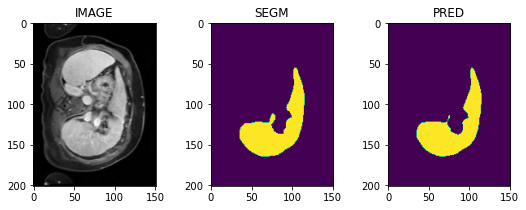

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E100998852_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.959678053855896
58.585834334803366
5.8752474135645985
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.9787378311157227
1.0
0.3677157716127799
torch.Size([1, 2, 190, 143, 120])
torch.Size([1, 190, 143, 120])


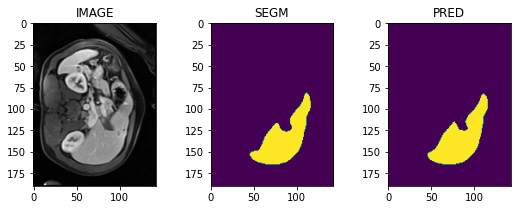

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/12370686_T1_PV_REG_segm.nii.gz
torch.Size([2, 220, 177, 120])
torch.Size([1, 220, 177, 120])
torch.Size([1, 2, 220, 177, 120])
0.9734756946563721
1.4142135623730951
0.3952008934527659
torch.Size([2, 220, 177, 120])
torch.Size([1, 220, 177, 120])
torch.Size([1, 2, 220, 177, 120])
0.9734756946563721
1.4142135623730951
0.3952008934527659
torch.Size([1, 2, 220, 177, 120])
torch.Size([1, 220, 177, 120])


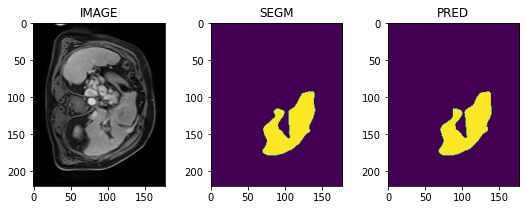

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E104184251_T1_PV_REG_segm.nii.gz
torch.Size([2, 230, 230, 144])
torch.Size([1, 230, 230, 144])
torch.Size([1, 2, 230, 230, 144])
0.955172598361969
60.86706818306859
8.264618846944133
torch.Size([2, 230, 230, 144])
torch.Size([1, 230, 230, 144])
torch.Size([1, 2, 230, 230, 144])
0.9777131080627441
1.0
0.38226290487247505
torch.Size([1, 2, 230, 230, 144])
torch.Size([1, 230, 230, 144])


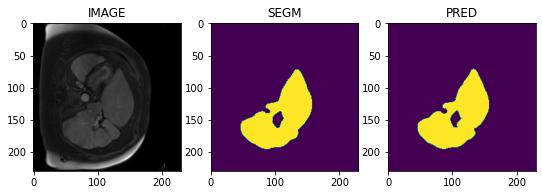

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E100353838_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 158, 95])
torch.Size([1, 210, 158, 95])
torch.Size([1, 2, 210, 158, 95])
0.9293641448020935
70.28513356322232
21.433893702705095
torch.Size([2, 210, 158, 95])
torch.Size([1, 210, 158, 95])
torch.Size([1, 2, 210, 158, 95])
0.9625021815299988
2.23606797749979
0.5817031894385782
torch.Size([1, 2, 210, 158, 95])
torch.Size([1, 210, 158, 95])


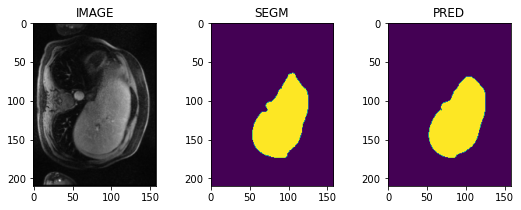

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/11655071_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.9667895436286926
1.4142135623730951
0.4122474412107193
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.9667895436286926
1.4142135623730951
0.4122474412107193
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


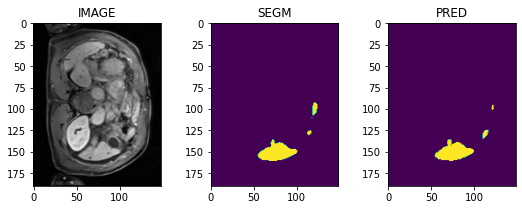

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E105258820_T1_PV_REG_segm.nii.gz
torch.Size([2, 180, 169, 140])
torch.Size([1, 180, 169, 140])
torch.Size([1, 2, 180, 169, 140])
0.901394248008728
66.05338747769535
13.158228375309047
torch.Size([2, 180, 169, 140])
torch.Size([1, 180, 169, 140])
torch.Size([1, 2, 180, 169, 140])
0.9779219031333923
1.7320508075688772
0.46661970961125776
torch.Size([1, 2, 180, 169, 140])
torch.Size([1, 180, 169, 140])


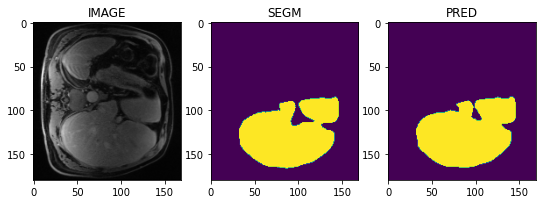

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/10782833_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.9774895906448364
1.0
1.652061865495658
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.9800324440002441
1.0
0.3178752801123224
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


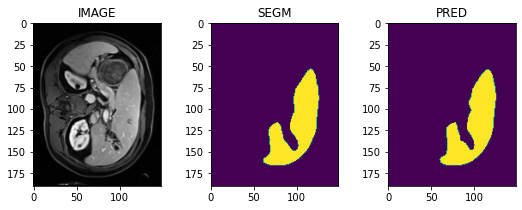

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E105047582_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 156, 120])
torch.Size([1, 200, 156, 120])
torch.Size([1, 2, 200, 156, 120])
0.9184514880180359
70.58045046580132
12.915634091756399
torch.Size([2, 200, 156, 120])
torch.Size([1, 200, 156, 120])
torch.Size([1, 2, 200, 156, 120])
0.9549493193626404
2.0
0.6430015208453452
torch.Size([1, 2, 200, 156, 120])
torch.Size([1, 200, 156, 120])


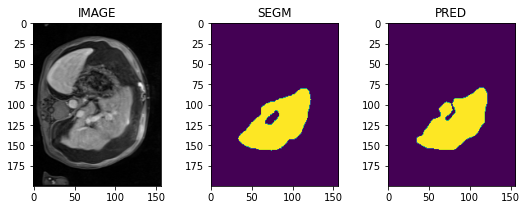

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E100559269_T1_PV_REG_segm.nii.gz
torch.Size([2, 180, 147, 132])
torch.Size([1, 180, 147, 132])
torch.Size([1, 2, 180, 147, 132])
0.8558523058891296
51.507281038703645
8.738446295250736
torch.Size([2, 180, 147, 132])
torch.Size([1, 180, 147, 132])
torch.Size([1, 2, 180, 147, 132])
0.8558523058891296
51.507281038703645
8.738446295250736
torch.Size([1, 2, 180, 147, 132])
torch.Size([1, 180, 147, 132])


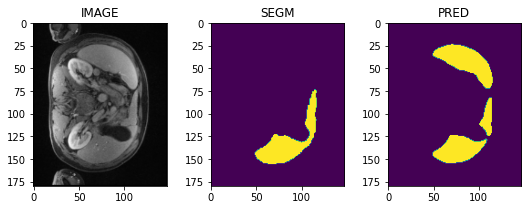

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/11157922_T1_PV_REG_segm.nii.gz
torch.Size([2, 203, 172, 116])
torch.Size([1, 203, 172, 116])
torch.Size([1, 2, 203, 172, 116])
0.9438035488128662
68.62834686360851
12.678807377757282
torch.Size([2, 203, 172, 116])
torch.Size([1, 203, 172, 116])
torch.Size([1, 2, 203, 172, 116])
0.9677287936210632
1.4142135623730951
0.627902273980682
torch.Size([1, 2, 203, 172, 116])
torch.Size([1, 203, 172, 116])


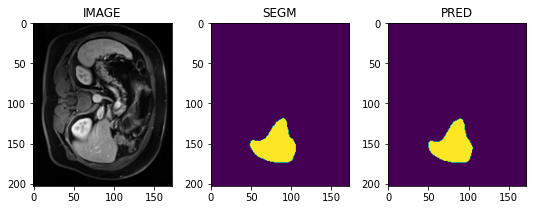

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E103977998_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 155, 120])
torch.Size([1, 190, 155, 120])
torch.Size([1, 2, 190, 155, 120])
0.969470739364624
1.7320508075688772
0.7221388541347762
torch.Size([2, 190, 155, 120])
torch.Size([1, 190, 155, 120])
torch.Size([1, 2, 190, 155, 120])
0.9702543020248413
1.7320508075688772
0.47347362150570965
torch.Size([1, 2, 190, 155, 120])
torch.Size([1, 190, 155, 120])


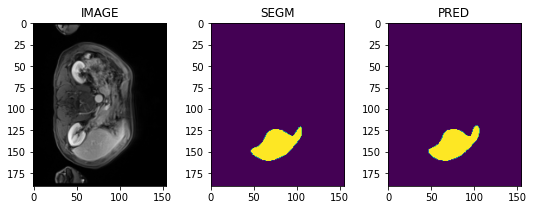

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E106605970_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.8274690508842468
68.48357467305573
19.92353707105357
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.9603423476219177
6.082762530298219
0.5542197560935201
torch.Size([1, 2, 200, 163, 120])
torch.Size([1, 200, 163, 120])


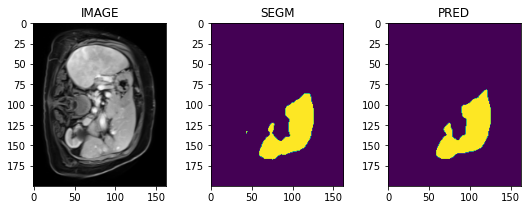

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E101166449_T1_PV_REG_segm.nii.gz
torch.Size([2, 221, 221, 110])
torch.Size([1, 221, 221, 110])
torch.Size([1, 2, 221, 221, 110])
0.9510096311569214
103.6445846236529
23.521315706802483
torch.Size([2, 221, 221, 110])
torch.Size([1, 221, 221, 110])
torch.Size([1, 2, 221, 221, 110])
0.9778651595115662
1.4142135623730951
0.35831308438965176
torch.Size([1, 2, 221, 221, 110])
torch.Size([1, 221, 221, 110])


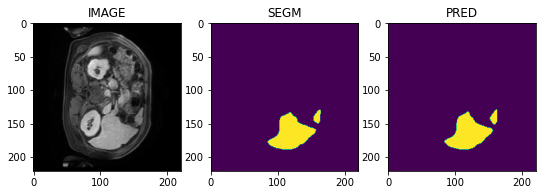

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E101693803_T1_PV_REG_segm.nii.gz
torch.Size([2, 205, 160, 120])
torch.Size([1, 205, 160, 120])
torch.Size([1, 2, 205, 160, 120])
0.9722986221313477
1.4142135623730951
1.235270874365205
torch.Size([2, 205, 160, 120])
torch.Size([1, 205, 160, 120])
torch.Size([1, 2, 205, 160, 120])
0.9760065674781799
1.4142135623730951
0.3496545554296642
torch.Size([1, 2, 205, 160, 120])
torch.Size([1, 205, 160, 120])


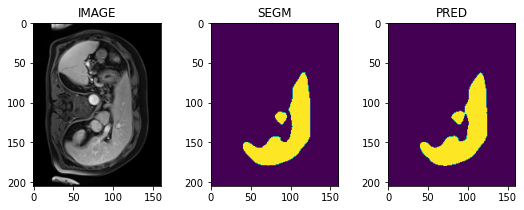

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E100488381_T1_PV_REG_segm.nii.gz
torch.Size([2, 225, 176, 132])
torch.Size([1, 225, 176, 132])
torch.Size([1, 2, 225, 176, 132])
0.971582293510437
1.7320508075688772
2.4923314742101046
torch.Size([2, 225, 176, 132])
torch.Size([1, 225, 176, 132])
torch.Size([1, 2, 225, 176, 132])
0.9740728139877319
1.7320508075688772
0.3971090789488092
torch.Size([1, 2, 225, 176, 132])
torch.Size([1, 225, 176, 132])


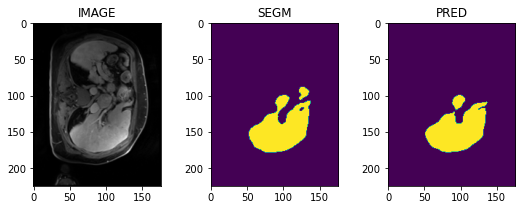

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E101446184_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 127, 108])
torch.Size([1, 190, 127, 108])
torch.Size([1, 2, 190, 127, 108])
0.9647283554077148
2.23606797749979
1.7354020775919365
torch.Size([2, 190, 127, 108])
torch.Size([1, 190, 127, 108])
torch.Size([1, 2, 190, 127, 108])
0.9654871821403503
2.23606797749979
0.4881998145422394
torch.Size([1, 2, 190, 127, 108])
torch.Size([1, 190, 127, 108])


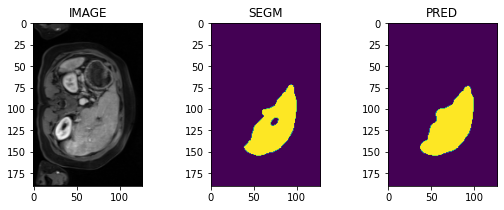

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/12132879_T1_PV_REG_segm.nii.gz
torch.Size([2, 250, 187, 132])
torch.Size([1, 250, 187, 132])
torch.Size([1, 2, 250, 187, 132])
0.9777634739875793
1.0
0.3667250148399701
torch.Size([2, 250, 187, 132])
torch.Size([1, 250, 187, 132])
torch.Size([1, 2, 250, 187, 132])
0.9777634739875793
1.0
0.3667250148399701
torch.Size([1, 2, 250, 187, 132])
torch.Size([1, 250, 187, 132])


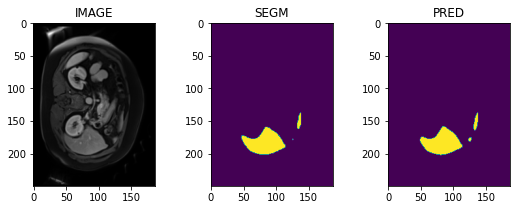

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E100207522_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 169, 120])
torch.Size([1, 210, 169, 120])
torch.Size([1, 2, 210, 169, 120])
0.8846797347068787
73.60706487831179
17.57464841106606
torch.Size([2, 210, 169, 120])
torch.Size([1, 210, 169, 120])
torch.Size([1, 2, 210, 169, 120])
0.9740365147590637
1.4142135623730951
0.4507584627792986
torch.Size([1, 2, 210, 169, 120])
torch.Size([1, 210, 169, 120])


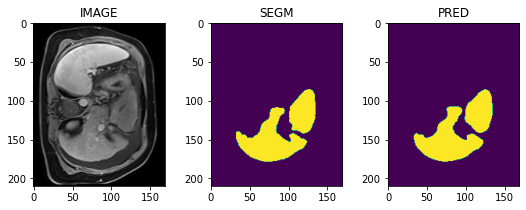

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E104350920_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.8696706295013428
66.15889962809237
17.823247049602234
torch.Size([2, 190, 143, 120])
torch.Size([1, 190, 143, 120])
torch.Size([1, 2, 190, 143, 120])
0.9601471424102783
1.7320508075688772
0.6133568091773088
torch.Size([1, 2, 190, 143, 120])
torch.Size([1, 190, 143, 120])


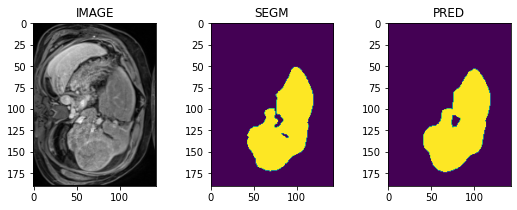

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E103442524_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 210, 132])
torch.Size([1, 210, 210, 132])
torch.Size([1, 2, 210, 210, 132])
0.9297354221343994
69.32532004974806
10.694291747715434
torch.Size([2, 210, 210, 132])
torch.Size([1, 210, 210, 132])
torch.Size([1, 2, 210, 210, 132])
0.9763199090957642
1.7320508075688772
0.4507674237757503
torch.Size([1, 2, 210, 210, 132])
torch.Size([1, 210, 210, 132])


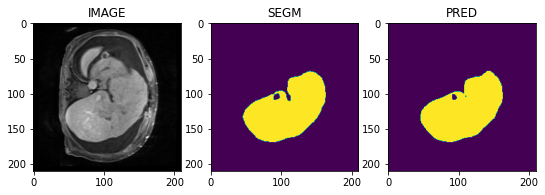

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E100354995_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 157, 120])
torch.Size([1, 200, 157, 120])
torch.Size([1, 2, 200, 157, 120])
0.9642561078071594
65.62469036930818
5.835019320952365
torch.Size([2, 200, 157, 120])
torch.Size([1, 200, 157, 120])
torch.Size([1, 2, 200, 157, 120])
0.9753108620643616
1.4142135623730951
0.4178522924639513
torch.Size([1, 2, 200, 157, 120])
torch.Size([1, 200, 157, 120])


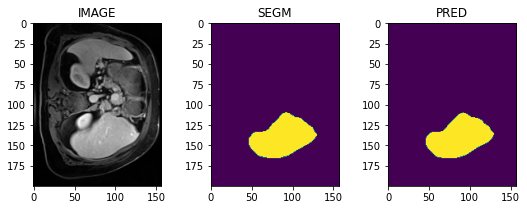

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/12169194_T1_PV_REG_segm.nii.gz
torch.Size([2, 191, 191, 88])
torch.Size([1, 191, 191, 88])
torch.Size([1, 2, 191, 191, 88])
0.9043686389923096
67.62432992202969
15.126113772542345
torch.Size([2, 191, 191, 88])
torch.Size([1, 191, 191, 88])
torch.Size([1, 2, 191, 191, 88])
0.9726359248161316
1.4142135623730951
0.41053709423526463
torch.Size([1, 2, 191, 191, 88])
torch.Size([1, 191, 191, 88])


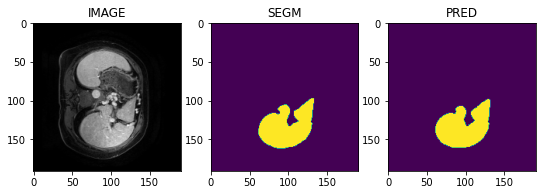

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/9464709_T1_PV_REG_segm.nii.gz
torch.Size([2, 221, 221, 144])
torch.Size([1, 221, 221, 144])
torch.Size([1, 2, 221, 221, 144])
0.8390663862228394
114.1910676463329
36.637407147844655
torch.Size([2, 221, 221, 144])
torch.Size([1, 221, 221, 144])
torch.Size([1, 2, 221, 221, 144])
0.976336658000946
1.4142135623730951
0.4069854508362482
torch.Size([1, 2, 221, 221, 144])
torch.Size([1, 221, 221, 144])


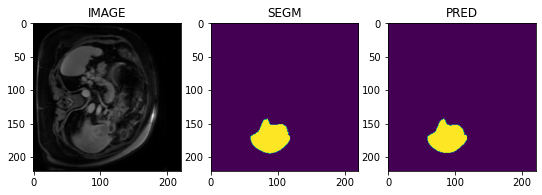

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E102885531_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 163, 108])
torch.Size([1, 200, 163, 108])
torch.Size([1, 2, 200, 163, 108])
0.9686889052391052
3.3166247903554
2.5201782481427366
torch.Size([2, 200, 163, 108])
torch.Size([1, 200, 163, 108])
torch.Size([1, 2, 200, 163, 108])
0.9712351560592651
1.4142135623730951
0.4539508490963511
torch.Size([1, 2, 200, 163, 108])
torch.Size([1, 200, 163, 108])


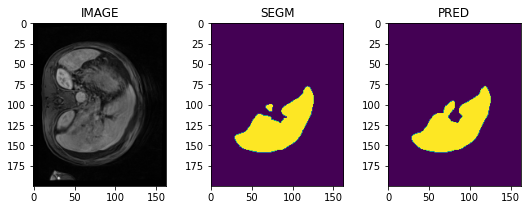

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E106731917_T1_PV_REG_segm.nii.gz
torch.Size([2, 211, 211, 131])
torch.Size([1, 211, 211, 131])
torch.Size([1, 2, 211, 211, 131])
0.93049156665802
83.16098840936024
12.323793016570232
torch.Size([2, 211, 211, 131])
torch.Size([1, 211, 211, 131])
torch.Size([1, 2, 211, 211, 131])
0.9678153991699219
2.23606797749979
0.502411067389601
torch.Size([1, 2, 211, 211, 131])
torch.Size([1, 211, 211, 131])


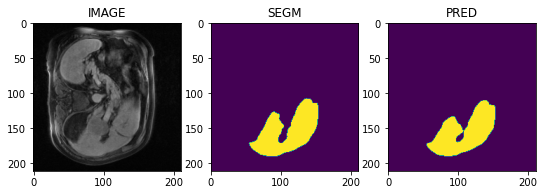

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E105877173_T1_PV_REG_segm.nii.gz
torch.Size([2, 175, 143, 108])
torch.Size([1, 175, 143, 108])
torch.Size([1, 2, 175, 143, 108])
0.9767171144485474
1.0
0.7767775413333552
torch.Size([2, 175, 143, 108])
torch.Size([1, 175, 143, 108])
torch.Size([1, 2, 175, 143, 108])
0.9772915840148926
1.0
0.36351742151182115
torch.Size([1, 2, 175, 143, 108])
torch.Size([1, 175, 143, 108])


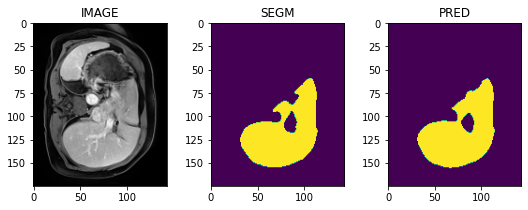

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E106096969_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 184, 120])
torch.Size([1, 190, 184, 120])
torch.Size([1, 2, 190, 184, 120])
0.9716958403587341
1.4142135623730951
1.1091736467295608
torch.Size([2, 190, 184, 120])
torch.Size([1, 190, 184, 120])
torch.Size([1, 2, 190, 184, 120])
0.9722699522972107
1.4142135623730951
0.4309567379328743
torch.Size([1, 2, 190, 184, 120])
torch.Size([1, 190, 184, 120])


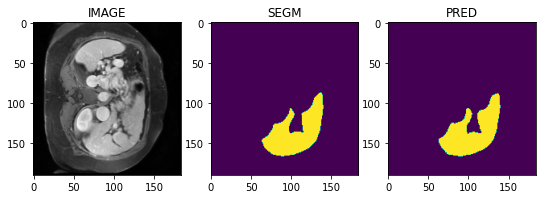

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/11571840_T1_PV_REG_segm.nii.gz
torch.Size([2, 220, 165, 131])
torch.Size([1, 220, 165, 131])
torch.Size([1, 2, 220, 165, 131])
0.9666510224342346
2.449489742783178
3.218107639645218
torch.Size([2, 220, 165, 131])
torch.Size([1, 220, 165, 131])
torch.Size([1, 2, 220, 165, 131])
0.9736348390579224
1.4142135623730951
0.4271689874964301
torch.Size([1, 2, 220, 165, 131])
torch.Size([1, 220, 165, 131])


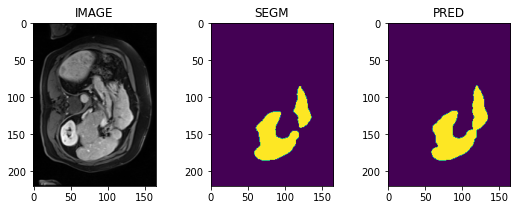

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E101753253_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 155, 120])
torch.Size([1, 190, 155, 120])
torch.Size([1, 2, 190, 155, 120])
0.9801079630851746
1.0
0.8724049777274563
torch.Size([2, 190, 155, 120])
torch.Size([1, 190, 155, 120])
torch.Size([1, 2, 190, 155, 120])
0.9805370569229126
1.0
0.3145160159452339
torch.Size([1, 2, 190, 155, 120])
torch.Size([1, 190, 155, 120])


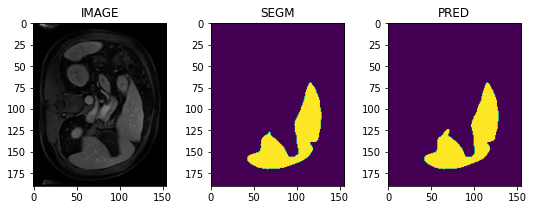

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E103922902_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9069727659225464
72.84092251242188
12.590358552167812
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9718220829963684
1.7320508075688772
0.507587400062007
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


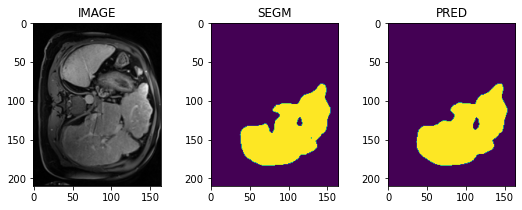

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E101453378_T1_PV_REG_segm.nii.gz
torch.Size([2, 180, 146, 102])
torch.Size([1, 180, 146, 102])
torch.Size([1, 2, 180, 146, 102])
0.9378101229667664
51.58778906169828
14.915147964987247
torch.Size([2, 180, 146, 102])
torch.Size([1, 180, 146, 102])
torch.Size([1, 2, 180, 146, 102])
0.9746963977813721
1.4142135623730951
0.4251274786469951
torch.Size([1, 2, 180, 146, 102])
torch.Size([1, 180, 146, 102])


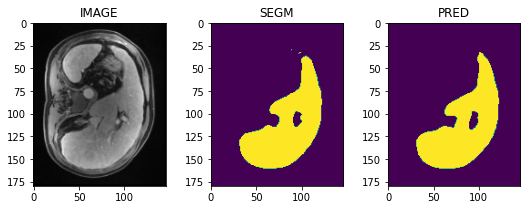

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/11397044_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.9636639952659607
37.220289613997295
3.3671158291480565
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.975591778755188
1.4142135623730951
0.39233273167565513
torch.Size([1, 2, 210, 158, 120])
torch.Size([1, 210, 158, 120])


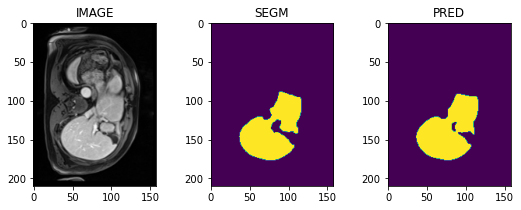

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/12922235_T1_PV_REG_segm.nii.gz
torch.Size([2, 185, 151, 120])
torch.Size([1, 185, 151, 120])
torch.Size([1, 2, 185, 151, 120])
0.9689921140670776
1.7320508075688772
0.49794484295708613
torch.Size([2, 185, 151, 120])
torch.Size([1, 185, 151, 120])
torch.Size([1, 2, 185, 151, 120])
0.9689943194389343
1.7320508075688772
0.49501575618066196
torch.Size([1, 2, 185, 151, 120])
torch.Size([1, 185, 151, 120])


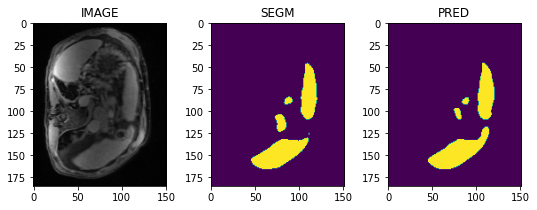

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/10939089_T1_PV_REG_segm.nii.gz
torch.Size([2, 225, 149, 144])
torch.Size([1, 225, 149, 144])
torch.Size([1, 2, 225, 149, 144])
0.9781400561332703
1.0
1.0099099377628253
torch.Size([2, 225, 149, 144])
torch.Size([1, 225, 149, 144])
torch.Size([1, 2, 225, 149, 144])
0.9801711440086365
1.0
0.32369977467470484
torch.Size([1, 2, 225, 149, 144])
torch.Size([1, 225, 149, 144])


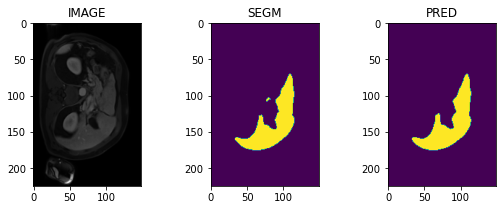

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/12957044_T1_PV_REG_segm.nii.gz
torch.Size([2, 220, 179, 120])
torch.Size([1, 220, 179, 120])
torch.Size([1, 2, 220, 179, 120])
0.9712269902229309
2.0
1.3144709173877496
torch.Size([2, 220, 179, 120])
torch.Size([1, 220, 179, 120])
torch.Size([1, 2, 220, 179, 120])
0.9724254608154297
2.0
0.4854906996165623
torch.Size([1, 2, 220, 179, 120])
torch.Size([1, 220, 179, 120])


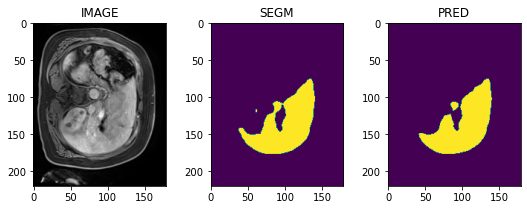

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E107891018_T1_PV_REG_segm.nii.gz
torch.Size([2, 201, 151, 132])
torch.Size([1, 201, 151, 132])
torch.Size([1, 2, 201, 151, 132])
0.9756973385810852
1.0
1.2276317917816044
torch.Size([2, 201, 151, 132])
torch.Size([1, 201, 151, 132])
torch.Size([1, 2, 201, 151, 132])
0.9762862324714661
1.0
0.3990599233392927
torch.Size([1, 2, 201, 151, 132])
torch.Size([1, 201, 151, 132])


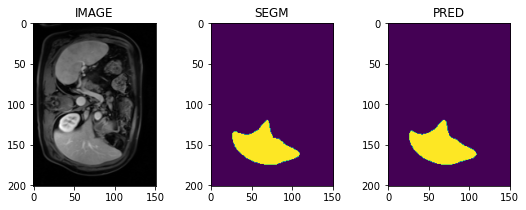

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E104332583_T1_PV_REG_segm.nii.gz
torch.Size([2, 220, 165, 144])
torch.Size([1, 220, 165, 144])
torch.Size([1, 2, 220, 165, 144])
0.9702252149581909
59.7109703754014
4.9496932175537225
torch.Size([2, 220, 165, 144])
torch.Size([1, 220, 165, 144])
torch.Size([1, 2, 220, 165, 144])
0.9814257025718689
1.0
0.35045768620591267
torch.Size([1, 2, 220, 165, 144])
torch.Size([1, 220, 165, 144])


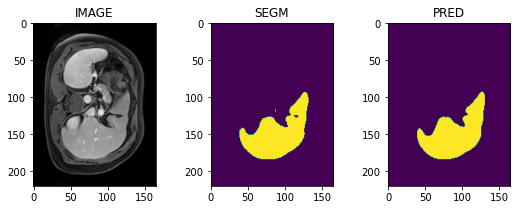

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E101547088_T1_PV_REG_segm.nii.gz
torch.Size([2, 195, 147, 139])
torch.Size([1, 195, 147, 139])
torch.Size([1, 2, 195, 147, 139])
0.9614534974098206
67.00186556775095
6.7498439018285215
torch.Size([2, 195, 147, 139])
torch.Size([1, 195, 147, 139])
torch.Size([1, 2, 195, 147, 139])
0.97698974609375
1.4142135623730951
0.3790330732698792
torch.Size([1, 2, 195, 147, 139])
torch.Size([1, 195, 147, 139])


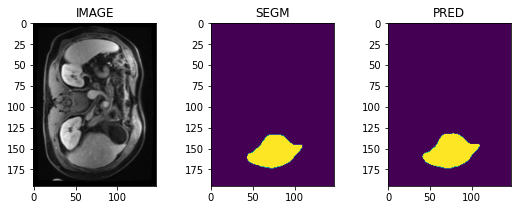

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/11524268_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 155, 132])
torch.Size([1, 190, 155, 132])
torch.Size([1, 2, 190, 155, 132])
0.9691967964172363
51.66236541235796
4.589820499373072
torch.Size([2, 190, 155, 132])
torch.Size([1, 190, 155, 132])
torch.Size([1, 2, 190, 155, 132])
0.9762289524078369
1.4142135623730951
0.35702441176342914
torch.Size([1, 2, 190, 155, 132])
torch.Size([1, 190, 155, 132])


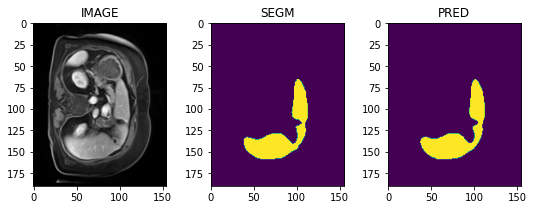

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E106458466_T1_PV_REG_segm.nii.gz
torch.Size([2, 197, 160, 96])
torch.Size([1, 197, 160, 96])
torch.Size([1, 2, 197, 160, 96])
0.9603854417800903
23.71918454125825
2.577439303535875
torch.Size([2, 197, 160, 96])
torch.Size([1, 197, 160, 96])
torch.Size([1, 2, 197, 160, 96])
0.9646693468093872
1.7320508075688772
0.48661370013498917
torch.Size([1, 2, 197, 160, 96])
torch.Size([1, 197, 160, 96])


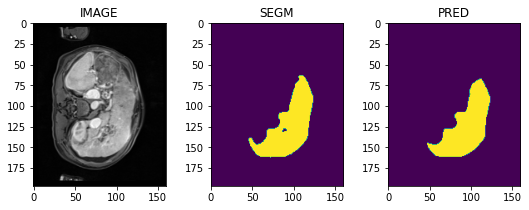

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E107235152_T1_PV_REG_segm.nii.gz
torch.Size([2, 201, 201, 123])
torch.Size([1, 201, 201, 123])
torch.Size([1, 2, 201, 201, 123])
0.9689657688140869
1.4142135623730951
0.47851358866574195
torch.Size([2, 201, 201, 123])
torch.Size([1, 201, 201, 123])
torch.Size([1, 2, 201, 201, 123])
0.9689657688140869
1.4142135623730951
0.47851358866574195
torch.Size([1, 2, 201, 201, 123])
torch.Size([1, 201, 201, 123])


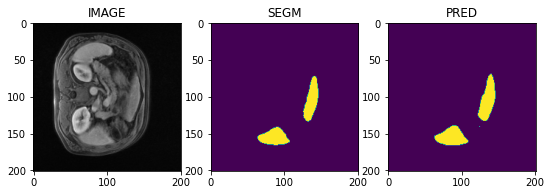

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E105198762_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 164, 144])
torch.Size([1, 190, 164, 144])
torch.Size([1, 2, 190, 164, 144])
0.8985475301742554
68.22023160324215
14.64208700497419
torch.Size([2, 190, 164, 144])
torch.Size([1, 190, 164, 144])
torch.Size([1, 2, 190, 164, 144])
0.9677802324295044
2.23606797749979
0.59698733890478
torch.Size([1, 2, 190, 164, 144])
torch.Size([1, 190, 164, 144])


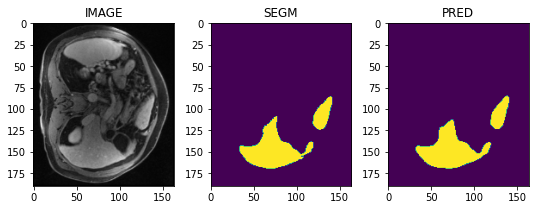

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/11148247_T1_PV_REG_segm.nii.gz
torch.Size([2, 196, 192, 120])
torch.Size([1, 196, 192, 120])
torch.Size([1, 2, 196, 192, 120])
0.9783782958984375
1.4142135623730951
0.40800203018407216
torch.Size([2, 196, 192, 120])
torch.Size([1, 196, 192, 120])
torch.Size([1, 2, 196, 192, 120])
0.9783934950828552
1.4142135623730951
0.3866485526914759
torch.Size([1, 2, 196, 192, 120])
torch.Size([1, 196, 192, 120])


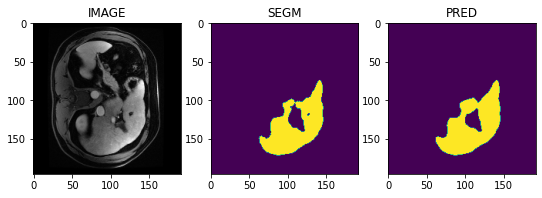

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E106751045_T1_PV_REG_segm.nii.gz
torch.Size([2, 186, 186, 92])
torch.Size([1, 186, 186, 92])
torch.Size([1, 2, 186, 186, 92])
0.9127217531204224
50.96076922496363
4.6290199953273
torch.Size([2, 186, 186, 92])
torch.Size([1, 186, 186, 92])
torch.Size([1, 2, 186, 186, 92])
0.923170268535614
9.433981132056603
0.6683735140616431
torch.Size([1, 2, 186, 186, 92])
torch.Size([1, 186, 186, 92])


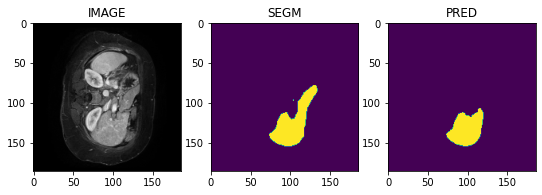

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/9648994_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 148, 142])
torch.Size([1, 190, 148, 142])
torch.Size([1, 2, 190, 148, 142])
0.8289210200309753
82.90536769330419
22.76047354583555
torch.Size([2, 190, 148, 142])
torch.Size([1, 190, 148, 142])
torch.Size([1, 2, 190, 148, 142])
0.9763261675834656
1.4142135623730951
0.4166104237438573
torch.Size([1, 2, 190, 148, 142])
torch.Size([1, 190, 148, 142])


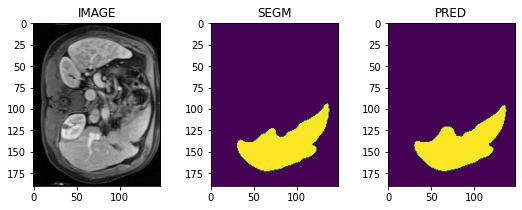

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E102928841_T1_PV_REG_segm.nii.gz
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.9762859344482422
1.0
1.5016902303725708
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.9785831570625305
1.0
0.3714464575392237
torch.Size([1, 2, 201, 151, 120])
torch.Size([1, 201, 151, 120])


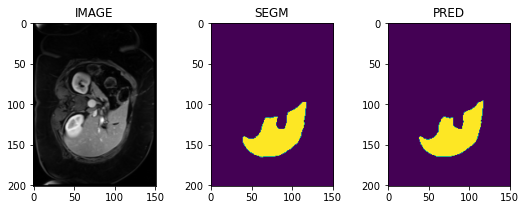

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E105426183_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 163, 116])
torch.Size([1, 200, 163, 116])
torch.Size([1, 2, 200, 163, 116])
0.872668445110321
77.49451587053858
21.80567784819953
torch.Size([2, 200, 163, 116])
torch.Size([1, 200, 163, 116])
torch.Size([1, 2, 200, 163, 116])
0.9774232506752014
1.0
0.4159197891105344
torch.Size([1, 2, 200, 163, 116])
torch.Size([1, 200, 163, 116])


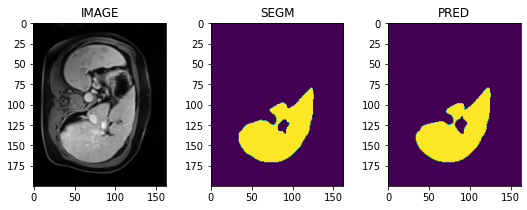

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E100142484_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 155, 132])
torch.Size([1, 190, 155, 132])
torch.Size([1, 2, 190, 155, 132])
0.9800585508346558
1.4142135623730951
1.7888456899809742
torch.Size([2, 190, 155, 132])
torch.Size([1, 190, 155, 132])
torch.Size([1, 2, 190, 155, 132])
0.9820643067359924
1.0
0.3600527476401861
torch.Size([1, 2, 190, 155, 132])
torch.Size([1, 190, 155, 132])


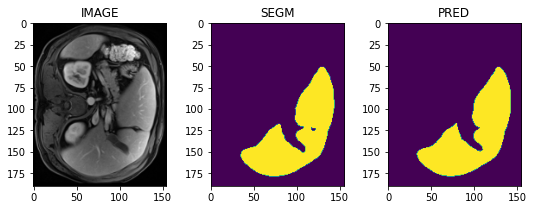

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E105829099_T1_PV_REG_segm.nii.gz
torch.Size([2, 201, 201, 92])
torch.Size([1, 201, 201, 92])
torch.Size([1, 2, 201, 201, 92])
0.936169445514679
4.898979485566356
2.808877147707635
torch.Size([2, 201, 201, 92])
torch.Size([1, 201, 201, 92])
torch.Size([1, 2, 201, 201, 92])
0.9382279515266418
4.898979485566356
0.6933244104833699
torch.Size([1, 2, 201, 201, 92])
torch.Size([1, 201, 201, 92])


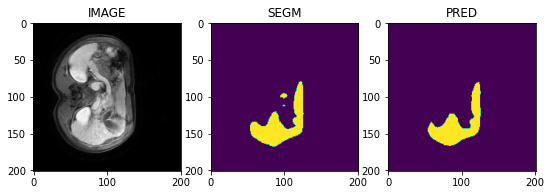

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/9586289_T1_PV_REG_segm.nii.gz
torch.Size([2, 170, 133, 108])
torch.Size([1, 170, 133, 108])
torch.Size([1, 2, 170, 133, 108])
0.8746031522750854
38.80914749262676
7.034510258419365
torch.Size([2, 170, 133, 108])
torch.Size([1, 170, 133, 108])
torch.Size([1, 2, 170, 133, 108])
0.9292304515838623
3.0
0.6660457777931947
torch.Size([1, 2, 170, 133, 108])
torch.Size([1, 170, 133, 108])


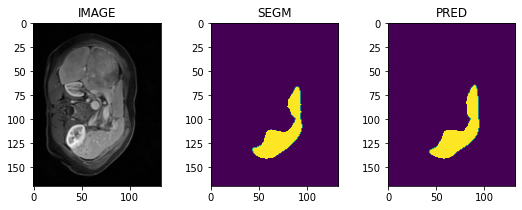

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E107156072_T1_PV_REG_segm.nii.gz
torch.Size([2, 220, 174, 108])
torch.Size([1, 220, 174, 108])
torch.Size([1, 2, 220, 174, 108])
0.9776841998100281
1.4142135623730951
2.7475243001189247
torch.Size([2, 220, 174, 108])
torch.Size([1, 220, 174, 108])
torch.Size([1, 2, 220, 174, 108])
0.9801419377326965
1.4142135623730951
0.3395646725971096
torch.Size([1, 2, 220, 174, 108])
torch.Size([1, 220, 174, 108])


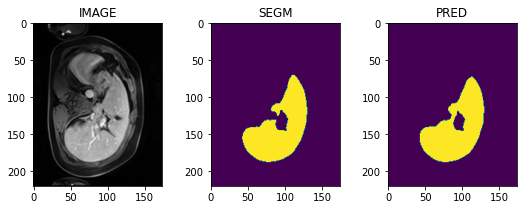

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E104998309_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 173, 120])
torch.Size([1, 200, 173, 120])
torch.Size([1, 2, 200, 173, 120])
0.9275749325752258
68.09552114493287
12.016184403193982
torch.Size([2, 200, 173, 120])
torch.Size([1, 200, 173, 120])
torch.Size([1, 2, 200, 173, 120])
0.9788571000099182
1.4142135623730951
0.4023670816645242
torch.Size([1, 2, 200, 173, 120])
torch.Size([1, 200, 173, 120])


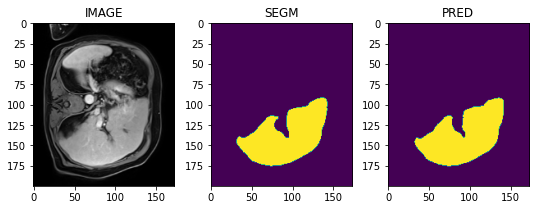

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E105615985_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 149, 132])
torch.Size([1, 190, 149, 132])
torch.Size([1, 2, 190, 149, 132])
0.9725820422172546
1.7320508075688772
2.2424437931658407
torch.Size([2, 190, 149, 132])
torch.Size([1, 190, 149, 132])
torch.Size([1, 2, 190, 149, 132])
0.9762484431266785
1.4142135623730951
0.405112996305091
torch.Size([1, 2, 190, 149, 132])
torch.Size([1, 190, 149, 132])


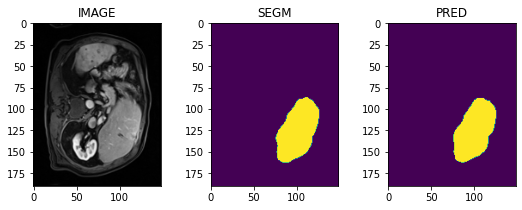

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/12916368_T1_PV_REG_segm.nii.gz
torch.Size([2, 211, 181, 116])
torch.Size([1, 211, 181, 116])
torch.Size([1, 2, 211, 181, 116])
0.9375977516174316
97.30878685915265
21.541703881447084
torch.Size([2, 211, 181, 116])
torch.Size([1, 211, 181, 116])
torch.Size([1, 2, 211, 181, 116])
0.9795096516609192
1.4142135623730951
0.46363457348021264
torch.Size([1, 2, 211, 181, 116])
torch.Size([1, 211, 181, 116])


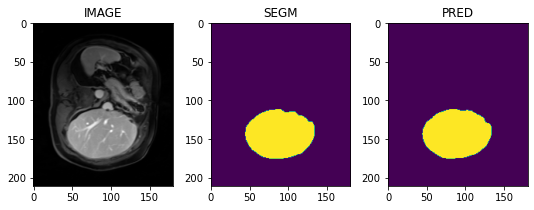

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E103814356_T1_PV_REG_segm.nii.gz
torch.Size([2, 170, 144, 150])
torch.Size([1, 170, 144, 150])
torch.Size([1, 2, 170, 144, 150])
0.9328575134277344
5.744562646538029
2.6369827627460545
torch.Size([2, 170, 144, 150])
torch.Size([1, 170, 144, 150])
torch.Size([1, 2, 170, 144, 150])
0.933605432510376
5.744562646538029
1.0786674045851998
torch.Size([1, 2, 170, 144, 150])
torch.Size([1, 170, 144, 150])


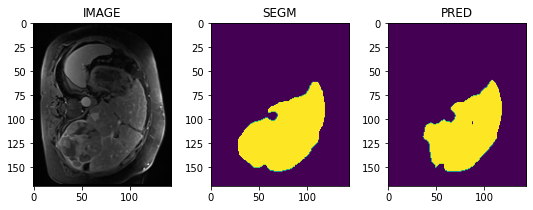

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/11022925_T1_PV_REG_segm.nii.gz
torch.Size([2, 206, 206, 110])
torch.Size([1, 206, 206, 110])
torch.Size([1, 2, 206, 206, 110])
0.8216047286987305
93.19871243745806
34.93818532374147
torch.Size([2, 206, 206, 110])
torch.Size([1, 206, 206, 110])
torch.Size([1, 2, 206, 206, 110])
0.9754809141159058
1.4142135623730951
0.39994004137566097
torch.Size([1, 2, 206, 206, 110])
torch.Size([1, 206, 206, 110])


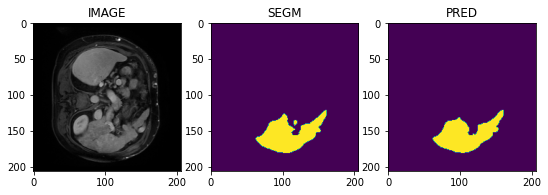

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E106533478_T1_PV_REG_segm.nii.gz
torch.Size([2, 191, 143, 132])
torch.Size([1, 191, 143, 132])
torch.Size([1, 2, 191, 143, 132])
0.972760021686554
1.4142135623730951
0.400554864443982
torch.Size([2, 191, 143, 132])
torch.Size([1, 191, 143, 132])
torch.Size([1, 2, 191, 143, 132])
0.972760021686554
1.4142135623730951
0.400554864443982
torch.Size([1, 2, 191, 143, 132])
torch.Size([1, 191, 143, 132])


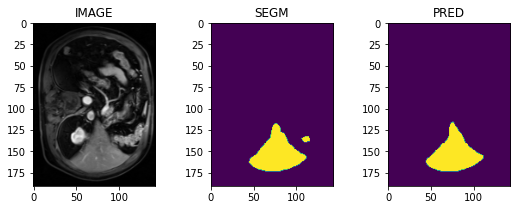

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E106851724_T1_PV_REG_segm.nii.gz
torch.Size([2, 181, 181, 135])
torch.Size([1, 181, 181, 135])
torch.Size([1, 2, 181, 181, 135])
0.8920827507972717
58.008620049092706
11.327329346681058
torch.Size([2, 181, 181, 135])
torch.Size([1, 181, 181, 135])
torch.Size([1, 2, 181, 181, 135])
0.9661633372306824
2.0
0.5354971948039976
torch.Size([1, 2, 181, 181, 135])
torch.Size([1, 181, 181, 135])


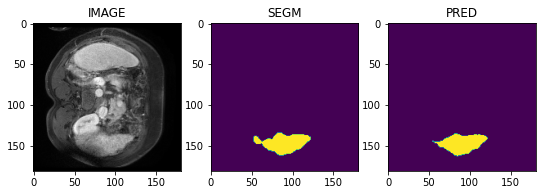

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E103511968_T1_PV_REG_segm.nii.gz
torch.Size([2, 215, 173, 120])
torch.Size([1, 215, 173, 120])
torch.Size([1, 2, 215, 173, 120])
0.9735361933708191
1.4142135623730951
1.650325653425537
torch.Size([2, 215, 173, 120])
torch.Size([1, 215, 173, 120])
torch.Size([1, 2, 215, 173, 120])
0.9764107465744019
1.0
0.38300552924495773
torch.Size([1, 2, 215, 173, 120])
torch.Size([1, 215, 173, 120])


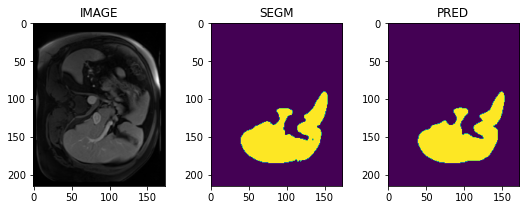

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E107553107_T1_PV_REG_segm.nii.gz
torch.Size([2, 201, 151, 111])
torch.Size([1, 201, 151, 111])
torch.Size([1, 2, 201, 151, 111])
0.9479958415031433
80.31189202104505
15.745554222419855
torch.Size([2, 201, 151, 111])
torch.Size([1, 201, 151, 111])
torch.Size([1, 2, 201, 151, 111])
0.9698665738105774
1.4142135623730951
0.4196714047105947
torch.Size([1, 2, 201, 151, 111])
torch.Size([1, 201, 151, 111])


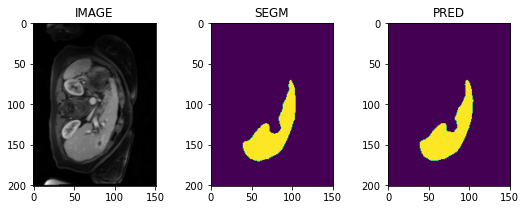

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E100588448_T1_PV_REG_segm.nii.gz
torch.Size([2, 236, 232, 120])
torch.Size([1, 236, 232, 120])
torch.Size([1, 2, 236, 232, 120])
0.974884033203125
2.0
0.6098316770845379
torch.Size([2, 236, 232, 120])
torch.Size([1, 236, 232, 120])
torch.Size([1, 2, 236, 232, 120])
0.9750292301177979
2.0
0.4647381265580945
torch.Size([1, 2, 236, 232, 120])
torch.Size([1, 236, 232, 120])


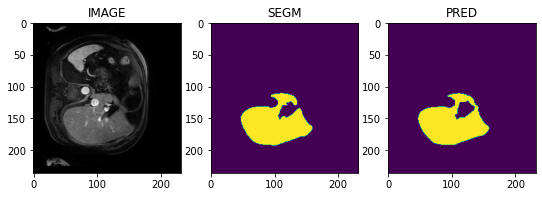

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E104134228_T1_PV_REG_segm.nii.gz
torch.Size([2, 211, 211, 110])
torch.Size([1, 211, 211, 110])
torch.Size([1, 2, 211, 211, 110])
0.9077439904212952
106.5861150426938
33.32718498760447
torch.Size([2, 211, 211, 110])
torch.Size([1, 211, 211, 110])
torch.Size([1, 2, 211, 211, 110])
0.9736009836196899
1.4142135623730951
0.4088467923134229
torch.Size([1, 2, 211, 211, 110])
torch.Size([1, 211, 211, 110])


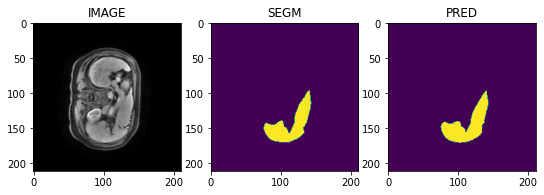

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E101686218_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 181, 108])
torch.Size([1, 210, 181, 108])
torch.Size([1, 2, 210, 181, 108])
0.9450443387031555
87.4202493312077
12.826812478197947
torch.Size([2, 210, 181, 108])
torch.Size([1, 210, 181, 108])
torch.Size([1, 2, 210, 181, 108])
0.9792210459709167
1.4142135623730951
0.3514467544007806
torch.Size([1, 2, 210, 181, 108])
torch.Size([1, 210, 181, 108])


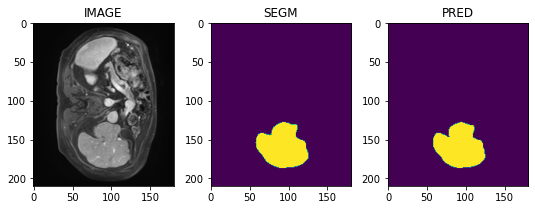

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E100967188_T1_PV_REG_segm.nii.gz
torch.Size([2, 225, 181, 131])
torch.Size([1, 225, 181, 131])
torch.Size([1, 2, 225, 181, 131])
0.9723493456840515
8.366600265340756
2.168717483758267
torch.Size([2, 225, 181, 131])
torch.Size([1, 225, 181, 131])
torch.Size([1, 2, 225, 181, 131])
0.976550817489624
1.4142135623730951
0.5882935827679568
torch.Size([1, 2, 225, 181, 131])
torch.Size([1, 225, 181, 131])


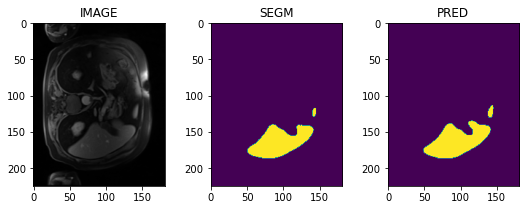

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E107476766_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 161, 115])
torch.Size([1, 200, 161, 115])
torch.Size([1, 2, 200, 161, 115])
0.8437204957008362
80.70563791203412
26.606178480200526
torch.Size([2, 200, 161, 115])
torch.Size([1, 200, 161, 115])
torch.Size([1, 2, 200, 161, 115])
0.9623976349830627
1.4142135623730951
0.4486771437339457
torch.Size([1, 2, 200, 161, 115])
torch.Size([1, 200, 161, 115])


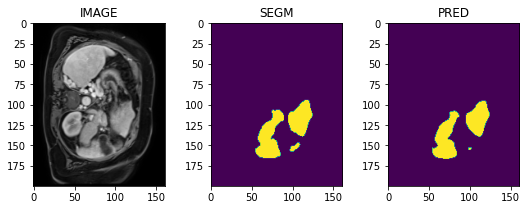

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E104250009_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 156, 132])
torch.Size([1, 200, 156, 132])
torch.Size([1, 2, 200, 156, 132])
0.973900318145752
62.279610557993315
4.0748043696112255
torch.Size([2, 200, 156, 132])
torch.Size([1, 200, 156, 132])
torch.Size([1, 2, 200, 156, 132])
0.9809505939483643
1.0
0.34430280814481956
torch.Size([1, 2, 200, 156, 132])
torch.Size([1, 200, 156, 132])


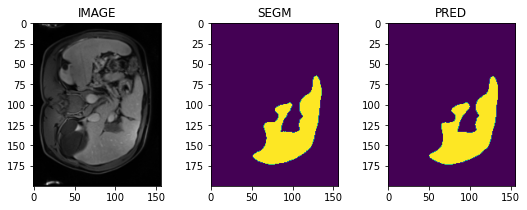

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E105152299_T1_PV_REG_segm.nii.gz
torch.Size([2, 192, 192, 108])
torch.Size([1, 192, 192, 108])
torch.Size([1, 2, 192, 192, 108])
0.8136277198791504
69.9721372790976
19.120925421251492
torch.Size([2, 192, 192, 108])
torch.Size([1, 192, 192, 108])
torch.Size([1, 2, 192, 192, 108])
0.9699459075927734
1.4142135623730951
0.4403196060259153
torch.Size([1, 2, 192, 192, 108])
torch.Size([1, 192, 192, 108])


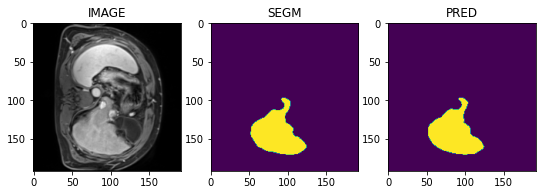

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/11308203_T1_PV_REG_segm.nii.gz
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.9793927073478699
1.0
1.0971793421756455
torch.Size([2, 201, 151, 120])
torch.Size([1, 201, 151, 120])
torch.Size([1, 2, 201, 151, 120])
0.9804071187973022
1.0
0.3567482055257917
torch.Size([1, 2, 201, 151, 120])
torch.Size([1, 201, 151, 120])


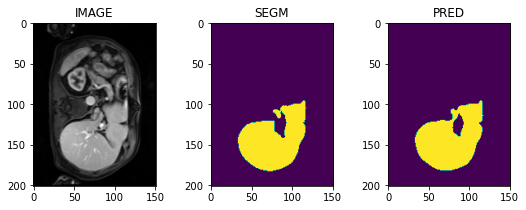

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E107046127_T1_PV_REG_segm.nii.gz
torch.Size([2, 230, 180, 120])
torch.Size([1, 230, 180, 120])
torch.Size([1, 2, 230, 180, 120])
0.9281623959541321
60.20548135772393
9.02808020924509
torch.Size([2, 230, 180, 120])
torch.Size([1, 230, 180, 120])
torch.Size([1, 2, 230, 180, 120])
0.9677863121032715
1.4142135623730951
0.43952878548804203
torch.Size([1, 2, 230, 180, 120])
torch.Size([1, 230, 180, 120])


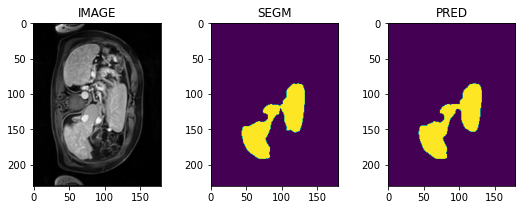

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/13106408_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.972832202911377
1.0
0.37258107449562844
torch.Size([2, 210, 158, 120])
torch.Size([1, 210, 158, 120])
torch.Size([1, 2, 210, 158, 120])
0.972832202911377
1.0
0.37258107449562844
torch.Size([1, 2, 210, 158, 120])
torch.Size([1, 210, 158, 120])


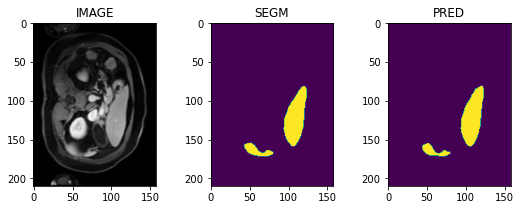

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E102486953_T1_PV_REG_segm.nii.gz
torch.Size([2, 170, 149, 120])
torch.Size([1, 170, 149, 120])
torch.Size([1, 2, 170, 149, 120])
0.897040069103241
57.787541754544606
11.537839890309671
torch.Size([2, 170, 149, 120])
torch.Size([1, 170, 149, 120])
torch.Size([1, 2, 170, 149, 120])
0.9742758274078369
1.0
0.36048369592894597
torch.Size([1, 2, 170, 149, 120])
torch.Size([1, 170, 149, 120])


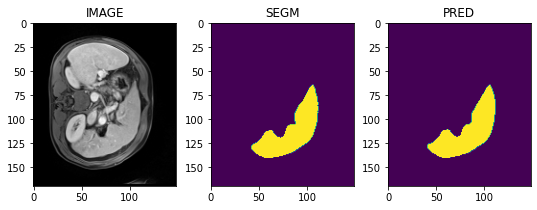

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E101055640_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 137, 120])
torch.Size([1, 200, 137, 120])
torch.Size([1, 2, 200, 137, 120])
0.9623169898986816
10.04987562112089
0.4626421012514396
torch.Size([2, 200, 137, 120])
torch.Size([1, 200, 137, 120])
torch.Size([1, 2, 200, 137, 120])
0.9623169898986816
10.04987562112089
0.4626421012514396
torch.Size([1, 2, 200, 137, 120])
torch.Size([1, 200, 137, 120])


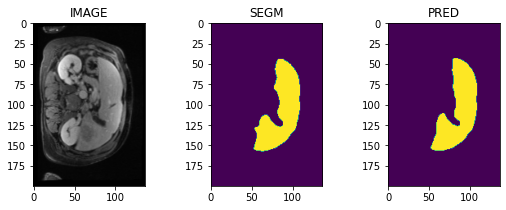

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/10807315_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9278162717819214
60.53924347066124
10.658356503335332
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9783082604408264
1.0
0.34344330676932416
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


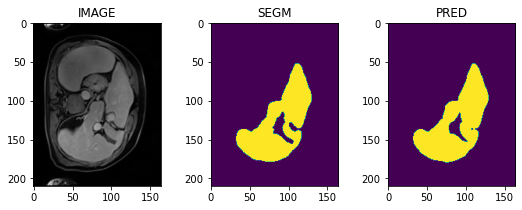

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/13170972_T1_PV_REG_segm.nii.gz
torch.Size([2, 205, 154, 155])
torch.Size([1, 205, 154, 155])
torch.Size([1, 2, 205, 154, 155])
0.841347336769104
84.27336471270148
18.49650907394655
torch.Size([2, 205, 154, 155])
torch.Size([1, 205, 154, 155])
torch.Size([1, 2, 205, 154, 155])
0.9246550798416138
6.324555320336759
1.3197427550377663
torch.Size([1, 2, 205, 154, 155])
torch.Size([1, 205, 154, 155])


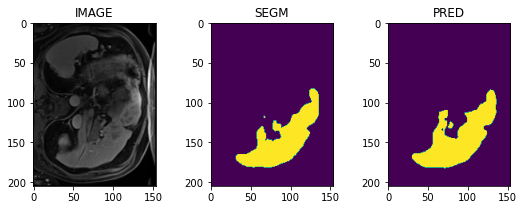

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E104594843_T1_PV_REG_segm.nii.gz
torch.Size([2, 231, 231, 144])
torch.Size([1, 231, 231, 144])
torch.Size([1, 2, 231, 231, 144])
0.9735621213912964
2.23606797749979
3.3767892836934283
torch.Size([2, 231, 231, 144])
torch.Size([1, 231, 231, 144])
torch.Size([1, 2, 231, 231, 144])
0.9786469340324402
1.4142135623730951
0.41118226873364155
torch.Size([1, 2, 231, 231, 144])
torch.Size([1, 231, 231, 144])


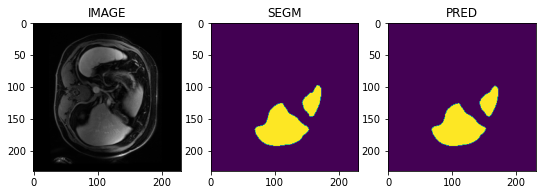

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E104034609_T1_PV_REG_segm.nii.gz
torch.Size([2, 191, 141, 120])
torch.Size([1, 191, 141, 120])
torch.Size([1, 2, 191, 141, 120])
0.919697105884552
75.7499174780451
14.095427206844306
torch.Size([2, 191, 141, 120])
torch.Size([1, 191, 141, 120])
torch.Size([1, 2, 191, 141, 120])
0.9791879057884216
1.0
0.37174320051415516
torch.Size([1, 2, 191, 141, 120])
torch.Size([1, 191, 141, 120])


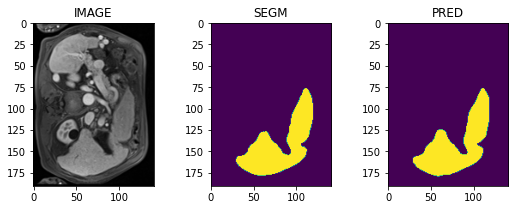

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E107774979_T1_PV_REG_segm.nii.gz
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9757580757141113
1.0
0.3527450398932396
torch.Size([2, 210, 164, 120])
torch.Size([1, 210, 164, 120])
torch.Size([1, 2, 210, 164, 120])
0.9757580757141113
1.0
0.3527450398932396
torch.Size([1, 2, 210, 164, 120])
torch.Size([1, 210, 164, 120])


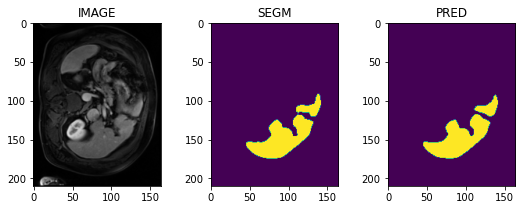

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E104900599_T1_PV_REG_segm.nii.gz
torch.Size([2, 230, 180, 142])
torch.Size([1, 230, 180, 142])
torch.Size([1, 2, 230, 180, 142])
0.9678238034248352
65.34064574173436
5.758499366150507
torch.Size([2, 230, 180, 142])
torch.Size([1, 230, 180, 142])
torch.Size([1, 2, 230, 180, 142])
0.9769702553749084
1.4142135623730951
0.38343331207086595
torch.Size([1, 2, 230, 180, 142])
torch.Size([1, 230, 180, 142])


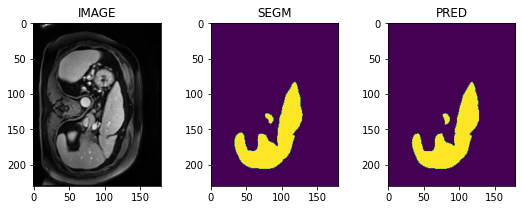

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E104657225_T1_PV_REG_segm.nii.gz
torch.Size([2, 180, 135, 108])
torch.Size([1, 180, 135, 108])
torch.Size([1, 2, 180, 135, 108])
0.9613981246948242
34.19064199455752
4.506525856199809
torch.Size([2, 180, 135, 108])
torch.Size([1, 180, 135, 108])
torch.Size([1, 2, 180, 135, 108])
0.9683486223220825
2.0
0.5274268115700528
torch.Size([1, 2, 180, 135, 108])
torch.Size([1, 180, 135, 108])


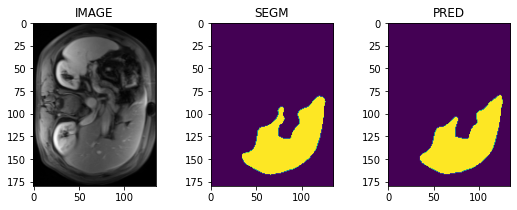

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E105599954_T1_PV_REG_segm.nii.gz
torch.Size([2, 235, 183, 132])
torch.Size([1, 235, 183, 132])
torch.Size([1, 2, 235, 183, 132])
0.930325984954834
63.53345563178733
9.37235346809283
torch.Size([2, 235, 183, 132])
torch.Size([1, 235, 183, 132])
torch.Size([1, 2, 235, 183, 132])
0.9683358669281006
2.23606797749979
0.5587912305261219
torch.Size([1, 2, 235, 183, 132])
torch.Size([1, 235, 183, 132])


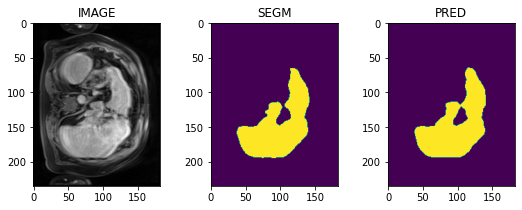

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E103570649_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 156, 127])
torch.Size([1, 200, 156, 127])
torch.Size([1, 2, 200, 156, 127])
0.9725991487503052
1.4142135623730951
0.41771160902105847
torch.Size([2, 200, 156, 127])
torch.Size([1, 200, 156, 127])
torch.Size([1, 2, 200, 156, 127])
0.9725991487503052
1.4142135623730951
0.41771160902105847
torch.Size([1, 2, 200, 156, 127])
torch.Size([1, 200, 156, 127])


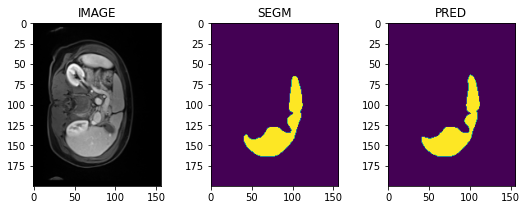

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E105504009_T1_PV_REG_segm.nii.gz
torch.Size([2, 211, 152, 104])
torch.Size([1, 211, 152, 104])
torch.Size([1, 2, 211, 152, 104])
0.9770218729972839
1.4142135623730951
0.4093257945117949
torch.Size([2, 211, 152, 104])
torch.Size([1, 211, 152, 104])
torch.Size([1, 2, 211, 152, 104])
0.97702556848526
1.4142135623730951
0.40749682076345645
torch.Size([1, 2, 211, 152, 104])
torch.Size([1, 211, 152, 104])


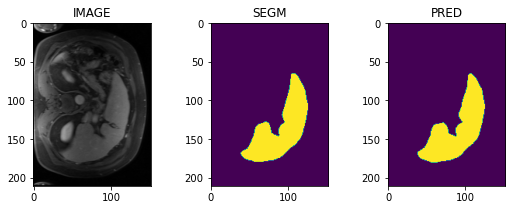

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E103831361_T1_PV_REG_segm.nii.gz
torch.Size([2, 221, 221, 119])
torch.Size([1, 221, 221, 119])
torch.Size([1, 2, 221, 221, 119])
0.9364427328109741
91.27978965795221
23.69202158956621
torch.Size([2, 221, 221, 119])
torch.Size([1, 221, 221, 119])
torch.Size([1, 2, 221, 221, 119])
0.974480926990509
1.4142135623730951
0.46087907496266006
torch.Size([1, 2, 221, 221, 119])
torch.Size([1, 221, 221, 119])


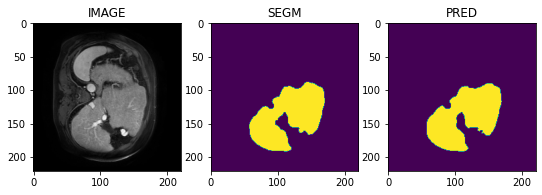

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/10843891_T1_PV_REG_segm.nii.gz
torch.Size([2, 175, 137, 120])
torch.Size([1, 175, 137, 120])
torch.Size([1, 2, 175, 137, 120])
0.9753744602203369
1.4142135623730951
0.4466172803876433
torch.Size([2, 175, 137, 120])
torch.Size([1, 175, 137, 120])
torch.Size([1, 2, 175, 137, 120])
0.9753744602203369
1.4142135623730951
0.4466172803876433
torch.Size([1, 2, 175, 137, 120])
torch.Size([1, 175, 137, 120])


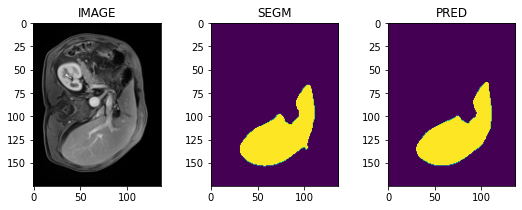

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E101762106_T1_PV_REG_segm.nii.gz
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.8042566776275635
85.98837130682264
29.53718396966871
torch.Size([2, 190, 149, 120])
torch.Size([1, 190, 149, 120])
torch.Size([1, 2, 190, 149, 120])
0.971087634563446
1.4142135623730951
0.4394942118024313
torch.Size([1, 2, 190, 149, 120])
torch.Size([1, 190, 149, 120])


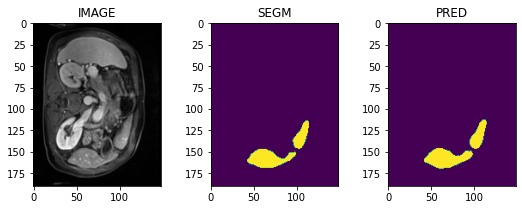

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/12543786_T1_PV_REG_segm.nii.gz
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.9667705297470093
1.4142135623730951
0.5493937183506276
torch.Size([2, 200, 163, 120])
torch.Size([1, 200, 163, 120])
torch.Size([1, 2, 200, 163, 120])
0.9669800996780396
1.4142135623730951
0.46047719054743463
torch.Size([1, 2, 200, 163, 120])
torch.Size([1, 200, 163, 120])


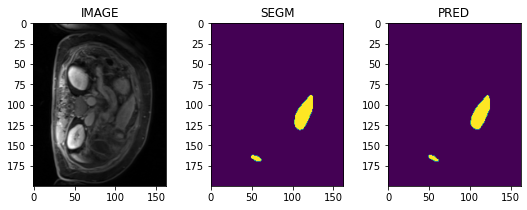

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E107077373_T1_PV_REG_segm.nii.gz
torch.Size([2, 220, 172, 120])
torch.Size([1, 220, 172, 120])
torch.Size([1, 2, 220, 172, 120])
0.9773024320602417
1.0
0.5013633736730514
torch.Size([2, 220, 172, 120])
torch.Size([1, 220, 172, 120])
torch.Size([1, 2, 220, 172, 120])
0.9774537086486816
1.0
0.37564559227703825
torch.Size([1, 2, 220, 172, 120])
torch.Size([1, 220, 172, 120])


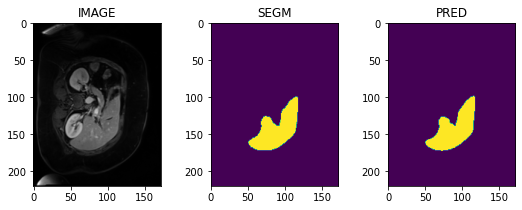

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/E106501028_T1_PV_REG_segm.nii.gz
[0.9394692778587341, 0.959678053855896, 0.9734756946563721, 0.955172598361969, 0.9293641448020935, 0.9667895436286926, 0.901394248008728, 0.9774895906448364, 0.9184514880180359, 0.8558523058891296, 0.9438035488128662, 0.969470739364624, 0.8274690508842468, 0.9510096311569214, 0.9722986221313477, 0.971582293510437, 0.9647283554077148, 0.9777634739875793, 0.8846797347068787, 0.8696706295013428, 0.9297354221343994, 0.9642561078071594, 0.9043686389923096, 0.8390663862228394, 0.9686889052391052, 0.93049156665802, 0.9767171144485474, 0.9716958403587341, 0.9666510224342346, 0.9801079630851746, 0.9069727659225464, 0.9378101229667664, 0.9636639952659607, 0.9689921140670776, 0.9781400561332703, 0.9712269902229309, 0.9756973385810852, 0.9702252149581909, 0.9614534974098206, 0.9691967964172363, 0.9603854417800903, 0.9689657688140869, 0.8985475301742554, 0.9783782958984375, 0.91272

DICE  POST_DICE       HD95  POST_HD95  InferenceTime  \
0  0.939469   0.972248  50.734604   1.414214       0.014280   
1  0.959678   0.978738  58.585834   1.000000       0.012206   
2  0.973476   0.973476   1.414214   1.414214       0.013356   
3  0.955173   0.977713  60.867068   1.000000       0.015758   
4  0.929364   0.962502  70.285134   2.236068       0.017896   

                                AUTOMATED-LIVER-SEGM        EXPERIMENT_ID  
0  /tensor5/data1/mgross/Liver/studies/Contrast-N...  PV-Contrast-Imaging  
1  /tensor5/data1/mgross/Liver/studies/Contrast-N...  PV-Contrast-Imaging  
2  /tensor5/data1/mgross/Liver/studies/Contrast-N...  PV-Contrast-Imaging  
3  /tensor5/data1/mgross/Liver/studies/Contrast-N...  PV-Contrast-Imaging  
4  /tensor5/data1/mgross/Liver/studies/Contrast-N...  PV-Contrast-Imaging

In [33]:
roi_size = (224, 224, 128)

df_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= test_loader, 
        roi_size=roi_size, 
        plot_images=True, 
        save_output=True,
        output_path= OUTPUT_PATH)


torch.cuda.empty_cache()
df_test_results['EXPERIMENT_ID'] = 'PV-Contrast-Imaging'
df_test_results.head()

In [37]:
for i in [df_test_results]:
    for idx, row in  i.iterrows():
            i.loc[idx, 'ACCESSION_ID'] = str(row['AUTOMATED-LIVER-SEGM'].split('/')[-1].split('_')[-5])


In [38]:
df_test_results.to_csv('Results/Results-PV-Net.csv')

# Public LiverHccSeg Dataset for Benchmark Testing

In [32]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import torch
import time


from monai.transforms import KeepLargestConnectedComponent
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm
from monai.data import decollate_batch




def compute_evaluation_metrics(y_pred, y, keep=False):
    
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    hd = monai.metrics.HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95, get_not_nans=False)
    mad = monai.metrics.SurfaceDistanceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep_largest = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    dice_list = list()
    hd_list = list()
    mad_list = list()
    for y_pred_i, y_i in decollate_batch((y_pred, y)):
        print(y_pred_i.shape)
        print(y_i.shape)
        if keep:
            #dice(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #hd(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #mad(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            y_pred_i_proc=one_hot(keep_largest(argmax(y_pred_i)))
        else:
                
            # Calculate Dice on the raw output
            #dice(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #hd(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #mad(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            y_pred_i_proc = one_hot(argmax(y_pred_i))
        y_pred_i_proc = monai.transforms.AddChannel()(y_pred_i_proc)
        y_i_proc = monai.transforms.AddChannel()(one_hot(y_i))
        print(y_pred_i_proc.shape)
            
        #dice(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #hd(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #mad(y_pred=y_pred_i_proc, y=one_hot(y_i))
            
        dice(y_pred=y_pred_i_proc, y=y_i_proc)
        hd(y_pred=y_pred_i_proc, y=y_i_proc)
        mad(y_pred=y_pred_i_proc, y=y_i_proc)
        
        dice_value = dice.aggregate().item()
        hd_value = hd.aggregate().item()
        mad_value = mad.aggregate().item()
        
        print(dice_value)
        print(hd_value)
        print(mad_value)
        
        dice_list.append(dice_value)
        hd_list.append(hd_value)
        mad_list.append(mad_value)
              
    return dice_list, hd_list, mad_list


def run_inference_and_evaluate(model, data_loader, plot_images=False, max_eval=None, 
                               save_output=False,roi_size=(224,224,128), sw_batch_size=4, output_path=None):
    
    """Inference and evaluation function for Liver segmentation.
    
    """   
    
    df_eval = pd.DataFrame()
    
    acc_ids = list()
    input_paths = list()
    output_paths = list()
    
    original_dice_results = list()
    postprocess_dice_results = list()

    original_hd_results = list()
    postprocess_hd_results = list()

    original_mad_results = list()
    postprocess_mad_results = list()
    
    inference_times = list()
    


    
    # Use MONAI one_hot transform
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    with torch.no_grad():
        for i, test_data in tqdm(enumerate(data_loader)):
        # Early stopping
            if max_eval is not None:
                if i>=max_eval:
                    break

            #print(test_data['ACCESSION_ID'][0])
            #for val in test_data['ACCESSION_ID'][0]:
            #    acc_ids.append(val)

    

            x = test_data['IMAGE'].to(device)
            y = test_data['SEGM'].cpu()

            start_time = time.time()
            y_pred = sliding_window_inference(x, roi_size, sw_batch_size, model)
            stop_time = time.time()

            inference_time = stop_time-start_time
            inference_times.append(inference_time)

            x = x.detach().cpu()
            y_pred = y_pred.detach().cpu()
            #print(y_pred.shape)

            #argmax = torch.argmax(y_pred, dim=1, keepdim=True)
            #argmax = argmax.detach().cpu()

            #y_onehot = one_hot(y)
            #y_pred_onehot = one_hot(argmax)

            # Evaluate segmentation metrics
            eval_list = list()
            # Update to MONAI 0.7+
            dice_values, hd_values, mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y
            )

            for val in dice_values:
                original_dice_results.append(val)
            for val in hd_values:
                original_hd_results.append(val)
            for val in mad_values:
                original_mad_results.append(val)



            post_dice_values, post_hd_values, post_mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y, keep=True
            )        #dice_list = list()
            #post_dice_list = list()

            for val in post_dice_values:
                postprocess_dice_results.append(val)
            for val in post_hd_values:
                postprocess_hd_results.append(val)
            for val in post_mad_values:
                postprocess_mad_results.append(val)





            print(y_pred.shape)
            print(argmax(y_pred[0,...]).shape)


            if plot_images:

                slice_num = x.shape[-1]//2

                plt.figure('check', (9, 3))
                plt.subplot(1, 3, 1)
                plt.title('IMAGE')
                plt.imshow(x[0,0,:,:,slice_num], cmap='gray')
 
                plt.subplot(1, 3, 2)
                plt.title('SEGM')
                plt.imshow(y[0,0,:,:,slice_num])

                plt.subplot(1, 3, 3)
                plt.title('PRED')
                #plt.imshow(argmax(y_pred[0,...])[0,:,:,slice_num])
                plt.imshow(keep(argmax(y_pred[0,...]))[0,:,:,slice_num])
                plt.show()


            # Write data out
            if save_output:
                # Get the image affine matrix
                current_affine = test_data['IMAGE_meta_dict']['affine'][0].numpy()
                original_affine = test_data['IMAGE_meta_dict']['original_affine'][0].numpy()
                original_spatial_shape = test_data['IMAGE_meta_dict']['spatial_shape'][0].numpy()

                input_file_name = test_data['IMAGE_meta_dict']['filename_or_obj'][0]
                output_file_name = os.path.split(input_file_name)[1]
                output_root_name = output_file_name[:-len('.nii.gz')]
                
                output_root_name = str(test_data['ACCESSION_ID'][0])
                
                output_path_final = os.path.join(output_path,'{}_segm.nii.gz'.format(output_root_name))
                print('Saving segmentation results: {}'.format(output_path_final))
                
                output_paths.append(output_path_final)
                
                #output_segm = argmax.cpu()[0, 0,...].numpy()
                output_segm = keep(argmax(y_pred[0,...])).cpu()[0,...].numpy()
                write_nifti(output_segm, output_path_final,
                            mode='nearest',
                            affine=current_affine, 
                            target_affine=original_affine,
                            output_spatial_shape=original_spatial_shape, 
                            dtype=np.float32
                           )

    
    #df_eval['ACCESSION_ID'] = acc_ids
    #df_eval['PV'] = input_paths
    df_eval['DICE'] = original_dice_results
    print(original_dice_results)
    df_eval['POST_DICE'] = postprocess_dice_results
    df_eval['HD95'] = original_hd_results
    df_eval['POST_HD95'] = postprocess_hd_results
    #df_eval['MAD'] = original_mad_results
    #df_eval['POST_MAD'] = postprocess_mad_results
    df_eval['InferenceTime'] = inference_times
    if output_path is not None:
        df_eval['AUTOMATED-LIVER-SEGM'] = output_paths    
    return df_eval


In [33]:
from monai.data import Dataset, DataLoader, pad_list_data_collate

In [43]:
## Load Public LiverHccSeg Dataset

import glob

LiverHccSeg_pre_path = '/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_and_segms/*/*/*art_pre.nii.gz'
LiverHccSeg_art_path = '/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_and_segms/*/*/*art.nii.gz'
LiverHccSeg_pv_path = '/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_and_segms/*/*/*art_pv.nii.gz'
LiverHccSeg_del_path = '/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_and_segms/*/*/*art_del.nii.gz'
LiverHccSeg_segm_path = '/tensor5/data1/mgross/Liver/LiverHccSeg/nifti_and_segms/*/*/*rater1_liver.nii.gz'

LiverHccSeg_pre_paths = glob.glob(LiverHccSeg_pre_path)
LiverHccSeg_art_paths = glob.glob(LiverHccSeg_art_path)
LiverHccSeg_pv_paths = glob.glob(LiverHccSeg_pv_path)
LiverHccSeg_del_paths = glob.glob(LiverHccSeg_del_path)
LiverHccSeg_segm_paths = glob.glob(LiverHccSeg_segm_path)

LiverHccSeg_accs = []
for i in LiverHccSeg_pre_paths:
    LiverHccSeg_accs.append(i.split('/')[-3])
    
df_LiverHccSeg_imgs = pd.DataFrame({'ACCESSION_ID': LiverHccSeg_accs, 'IMAGE' : LiverHccSeg_pv_paths, 
                                    #'PRE': LiverHccSeg_pre_paths, 'ART' : LiverHccSeg_art_paths, 'PV' : LiverHccSeg_pv_paths, 
                                   # 'DEL' : LiverHccSeg_del_paths, 
                                    'SEGM' : LiverHccSeg_segm_paths })

df_LiverHccSeg_imgs

ACCESSION_ID                                              IMAGE  \
0   TCGA-G3-A25T  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
1   TCGA-G3-AAV2  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
2   TCGA-G3-A3CJ  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
3   TCGA-DD-A4NH  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
4   TCGA-BC-4073  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
5   TCGA-DD-A4NB  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
6   TCGA-G3-A7M7  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
7   TCGA-G3-AAV1  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
8   TCGA-G3-AAV3  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
9   TCGA-G3-AAV7  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
10  TCGA-BC-A3KG  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
11  TCGA-BC-A69I  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
12  TCGA-BC-A5W4  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
13  TCGA-BC-A216  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
14  TCGA-BC-A10Y  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
15  TCGA-DD-A4NF  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   
16  TCGA-DD-A4NJ  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...   

                                                 SEGM  
0   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...  
1   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...  
2   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...  
3   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...  
4   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...  
5   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...  
6   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...  
7   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...  
8   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...  
9   /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...  
10  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...  
11  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...  
12  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...  
13  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...  
14  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...  
15  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...  
16  /tensor5/data1/mgross/Liver/LiverHccSeg/nifti_...

In [44]:
LiverHccSeg_test_data_dict = df_LiverHccSeg_imgs.to_dict('records')
print('Number of LiverHccSeg testing files: ', len(LiverHccSeg_test_data_dict))

Number of LiverHccSeg testing files:  17


In [45]:
LiverHccSeg_test_ds = monai.data.Dataset(
    data=LiverHccSeg_test_data_dict, transform=test_transforms)
LiverHccSeg_test_loader = DataLoader(LiverHccSeg_test_ds, batch_size=1, num_workers=4)

torch.Size([1, 1, 170, 107, 100])
TCGA-G3-A25T
IMAGE shape: torch.Size([170, 107, 100]), label shape: torch.Size([170, 107, 100])
IMAGE mean: 0.2101699411869049


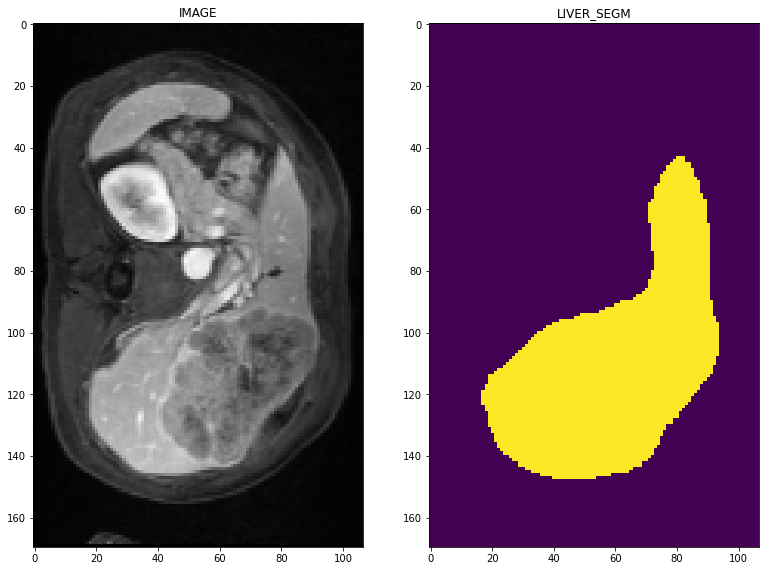

In [46]:
check_ds = monai.data.Dataset(data=LiverHccSeg_test_data_dict[:1], transform=test_transforms)


check_loader = DataLoader(check_ds, batch_size=10, num_workers=0 )
check_data = monai.utils.misc.first(check_loader)
print(check_data['IMAGE'].shape)


num_display = 10
if check_data['IMAGE'].shape[0] < num_display:
    num_display = check_data['IMAGE'].shape[0]

for i in range(num_display):
    acc_id, IMAGE , liver_label = (check_data['ACCESSION_ID'][i], check_data['IMAGE'][i][0], check_data['SEGM'][i][0])
    print(acc_id)
            
    print('IMAGE shape: {}, label shape: {}'.format(IMAGE.shape, liver_label.shape))
    print('IMAGE mean: {}'.format(np.mean(IMAGE.numpy())))

 
    slice_num = IMAGE.shape[2]//2
    
    plt.figure('check', (13, 15))
   

    plt.subplot(1, 2, 1)
    plt.title('IMAGE')
    plt.imshow(IMAGE[:,:,slice_num], cmap='gray')
    
    plt.subplot(1, 2, 2)
    plt.title('LIVER_SEGM')
    plt.imshow(liver_label[:,:,slice_num])
    plt.show()


    


In [38]:
OUTPUT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/LiverHccSeg'

0it [00:00, ?it/s]

torch.Size([2, 170, 107, 100])
torch.Size([1, 170, 107, 100])
torch.Size([1, 2, 170, 107, 100])
0.8211745619773865
11.532562594670797
3.1624597127175265
torch.Size([2, 170, 107, 100])
torch.Size([1, 170, 107, 100])
torch.Size([1, 2, 170, 107, 100])
0.8211745619773865
11.532562594670797
3.1624597127175265
torch.Size([1, 2, 170, 107, 100])
torch.Size([1, 170, 107, 100])


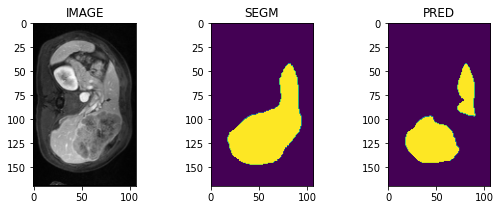

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/LiverHccSeg/TCGA-G3-A25T_segm.nii.gz
torch.Size([2, 180, 180, 110])
torch.Size([1, 180, 180, 110])
torch.Size([1, 2, 180, 180, 110])
0.9497272968292236
60.386253735137856
7.683024391926683
torch.Size([2, 180, 180, 110])
torch.Size([1, 180, 180, 110])
torch.Size([1, 2, 180, 180, 110])
0.9556570053100586
2.23606797749979
0.7592990660863622
torch.Size([1, 2, 180, 180, 110])
torch.Size([1, 180, 180, 110])


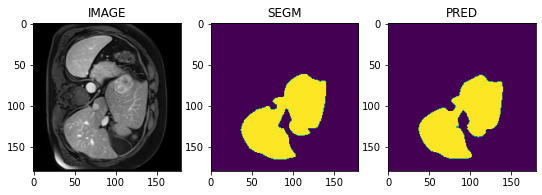

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/LiverHccSeg/TCGA-G3-AAV2_segm.nii.gz
torch.Size([2, 165, 98, 112])
torch.Size([1, 165, 98, 112])
torch.Size([1, 2, 165, 98, 112])
0.8825232982635498
15.165750888103101
2.573264891539993
torch.Size([2, 165, 98, 112])
torch.Size([1, 165, 98, 112])
torch.Size([1, 2, 165, 98, 112])
0.8825478553771973
15.165750888103101
2.5691212301607314
torch.Size([1, 2, 165, 98, 112])
torch.Size([1, 165, 98, 112])


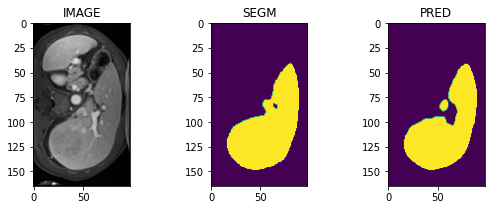

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/LiverHccSeg/TCGA-G3-A3CJ_segm.nii.gz
torch.Size([2, 201, 151, 86])
torch.Size([1, 201, 151, 86])
torch.Size([1, 2, 201, 151, 86])
0.5928700566291809
45.0
17.038925593586946
torch.Size([2, 201, 151, 86])
torch.Size([1, 201, 151, 86])
torch.Size([1, 2, 201, 151, 86])
0.7325029969215393
31.12876483254676
3.3747911772493526
torch.Size([1, 2, 201, 151, 86])
torch.Size([1, 201, 151, 86])


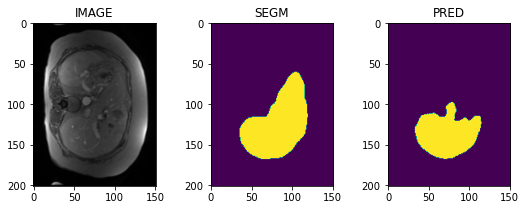

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/LiverHccSeg/TCGA-DD-A4NH_segm.nii.gz
torch.Size([2, 200, 150, 120])
torch.Size([1, 200, 150, 120])
torch.Size([1, 2, 200, 150, 120])
0.9527380466461182
2.23606797749979
0.8942576116082268
torch.Size([2, 200, 150, 120])
torch.Size([1, 200, 150, 120])
torch.Size([1, 2, 200, 150, 120])
0.952838659286499
2.23606797749979
0.7589435622735268
torch.Size([1, 2, 200, 150, 120])
torch.Size([1, 200, 150, 120])


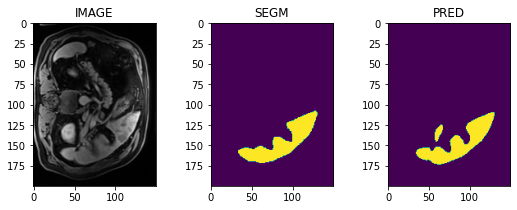

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/LiverHccSeg/TCGA-BC-4073_segm.nii.gz
torch.Size([2, 201, 200, 115])
torch.Size([1, 201, 200, 115])
torch.Size([1, 2, 201, 200, 115])
0.9166718125343323
54.8270006474912
8.739748208654678
torch.Size([2, 201, 200, 115])
torch.Size([1, 201, 200, 115])
torch.Size([1, 2, 201, 200, 115])
0.9358876347541809
2.8284271247461903
1.1107775113965228
torch.Size([1, 2, 201, 200, 115])
torch.Size([1, 201, 200, 115])


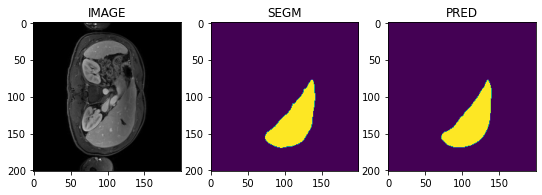

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/LiverHccSeg/TCGA-DD-A4NB_segm.nii.gz
torch.Size([2, 190, 155, 96])
torch.Size([1, 190, 155, 96])
torch.Size([1, 2, 190, 155, 96])
0.9392638802528381
16.315632071913733
2.271196119018857
torch.Size([2, 190, 155, 96])
torch.Size([1, 190, 155, 96])
torch.Size([1, 2, 190, 155, 96])
0.9417462348937988
5.0990195135927845
0.7714822437326728
torch.Size([1, 2, 190, 155, 96])
torch.Size([1, 190, 155, 96])


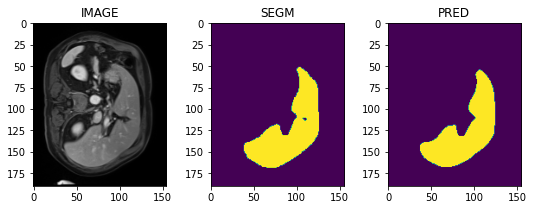

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/LiverHccSeg/TCGA-G3-A7M7_segm.nii.gz
torch.Size([2, 225, 204, 122])
torch.Size([1, 225, 204, 122])
torch.Size([1, 2, 225, 204, 122])
0.9131593704223633
4.123105625617661
1.1273105899370264
torch.Size([2, 225, 204, 122])
torch.Size([1, 225, 204, 122])
torch.Size([1, 2, 225, 204, 122])
0.9131593704223633
4.123105625617661
1.1273105899370264
torch.Size([1, 2, 225, 204, 122])
torch.Size([1, 225, 204, 122])


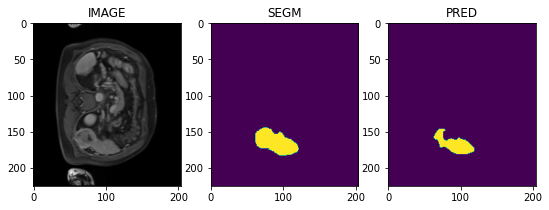

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/LiverHccSeg/TCGA-G3-AAV1_segm.nii.gz
torch.Size([2, 175, 175, 110])
torch.Size([1, 175, 175, 110])
torch.Size([1, 2, 175, 175, 110])
0.9352486729621887
53.772669035170395
9.422051495183789
torch.Size([2, 175, 175, 110])
torch.Size([1, 175, 175, 110])
torch.Size([1, 2, 175, 175, 110])
0.9439404606819153
2.8284271247461903
0.9971851896141931
torch.Size([1, 2, 175, 175, 110])
torch.Size([1, 175, 175, 110])


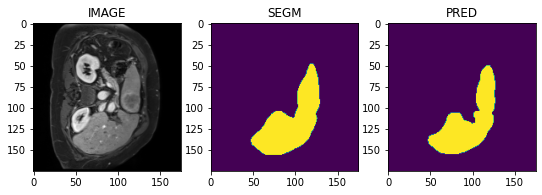

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/LiverHccSeg/TCGA-G3-AAV3_segm.nii.gz
torch.Size([2, 180, 119, 150])
torch.Size([1, 180, 119, 150])
torch.Size([1, 2, 180, 119, 150])
0.9263135194778442
5.656854249492381
0.8696525968242228
torch.Size([2, 180, 119, 150])
torch.Size([1, 180, 119, 150])
torch.Size([1, 2, 180, 119, 150])
0.9263135194778442
5.656854249492381
0.8696525968242228
torch.Size([1, 2, 180, 119, 150])
torch.Size([1, 180, 119, 150])


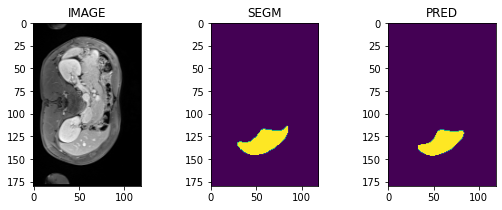

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/LiverHccSeg/TCGA-G3-AAV7_segm.nii.gz
torch.Size([2, 180, 147, 110])
torch.Size([1, 180, 147, 110])
torch.Size([1, 2, 180, 147, 110])
0.9392799735069275
57.857150935103085
10.206062558894512
torch.Size([2, 180, 147, 110])
torch.Size([1, 180, 147, 110])
torch.Size([1, 2, 180, 147, 110])
0.9499912858009338
4.69041575982343
1.2967692883466733
torch.Size([1, 2, 180, 147, 110])
torch.Size([1, 180, 147, 110])


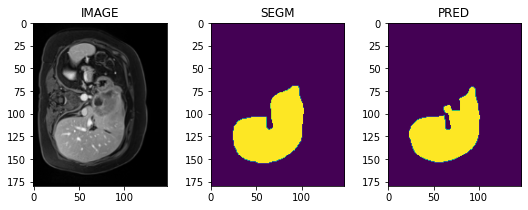

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/LiverHccSeg/TCGA-BC-A3KG_segm.nii.gz
torch.Size([2, 200, 163, 153])
torch.Size([1, 200, 163, 153])
torch.Size([1, 2, 200, 163, 153])
0.932179868221283
50.368641037852115
4.66490236921911
torch.Size([2, 200, 163, 153])
torch.Size([1, 200, 163, 153])
torch.Size([1, 2, 200, 163, 153])
0.9405819773674011
2.8284271247461903
0.9778140738481927
torch.Size([1, 2, 200, 163, 153])
torch.Size([1, 200, 163, 153])


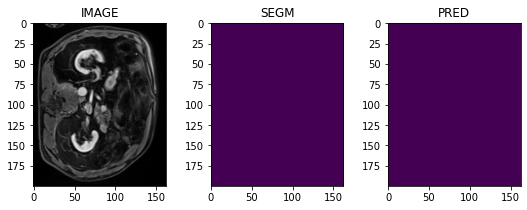

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/LiverHccSeg/TCGA-BC-A69I_segm.nii.gz
torch.Size([2, 215, 162, 125])
torch.Size([1, 215, 162, 125])
torch.Size([1, 2, 215, 162, 125])
0.8031650185585022
71.45628033979938
18.288060067872753
torch.Size([2, 215, 162, 125])
torch.Size([1, 215, 162, 125])
torch.Size([1, 2, 215, 162, 125])
0.9219712615013123
5.656854249492381
1.4836139458904076
torch.Size([1, 2, 215, 162, 125])
torch.Size([1, 215, 162, 125])


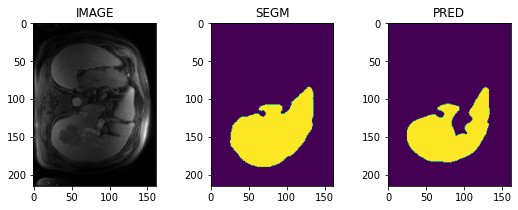

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/LiverHccSeg/TCGA-BC-A5W4_segm.nii.gz
torch.Size([2, 201, 201, 99])
torch.Size([1, 201, 201, 99])
torch.Size([1, 2, 201, 201, 99])
0.9144712686538696
81.43647826887329
16.0636236072838
torch.Size([2, 201, 201, 99])
torch.Size([1, 201, 201, 99])
torch.Size([1, 2, 201, 201, 99])
0.9301996231079102
5.385164807134504
1.1551377428443637
torch.Size([1, 2, 201, 201, 99])
torch.Size([1, 201, 201, 99])


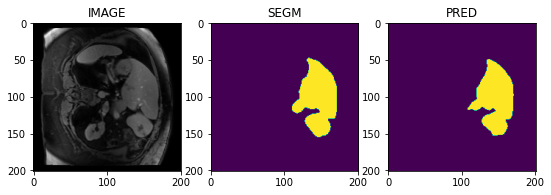

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/LiverHccSeg/TCGA-BC-A216_segm.nii.gz
torch.Size([2, 191, 143, 98])
torch.Size([1, 191, 143, 98])
torch.Size([1, 2, 191, 143, 98])
0.5184019804000854
66.83561924602779
23.87789765277199
torch.Size([2, 191, 143, 98])
torch.Size([1, 191, 143, 98])
torch.Size([1, 2, 191, 143, 98])
0.5278153419494629
62.30890743629009
21.211146180198416
torch.Size([1, 2, 191, 143, 98])
torch.Size([1, 191, 143, 98])


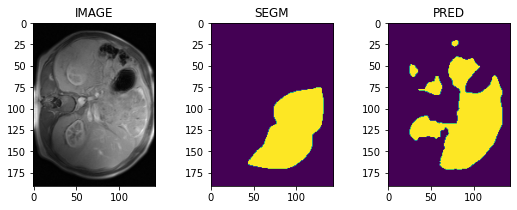

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/LiverHccSeg/TCGA-BC-A10Y_segm.nii.gz
torch.Size([2, 201, 151, 90])
torch.Size([1, 201, 151, 90])
torch.Size([1, 2, 201, 151, 90])
0.9124687910079956
3.4641016151377544
3.4225398178043567
torch.Size([2, 201, 151, 90])
torch.Size([1, 201, 151, 90])
torch.Size([1, 2, 201, 151, 90])
0.9170358180999756
3.3166247903554
1.0631712091890266
torch.Size([1, 2, 201, 151, 90])
torch.Size([1, 201, 151, 90])


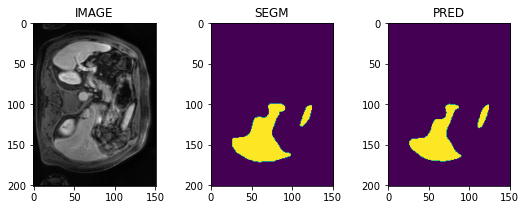

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/LiverHccSeg/TCGA-DD-A4NF_segm.nii.gz
torch.Size([2, 201, 151, 105])
torch.Size([1, 201, 151, 105])
torch.Size([1, 2, 201, 151, 105])
0.9098724126815796
76.56369897020389
6.466516282999707
torch.Size([2, 201, 151, 105])
torch.Size([1, 201, 151, 105])
torch.Size([1, 2, 201, 151, 105])
0.9207088351249695
3.605551275463989
1.4632706578105474
torch.Size([1, 2, 201, 151, 105])
torch.Size([1, 201, 151, 105])


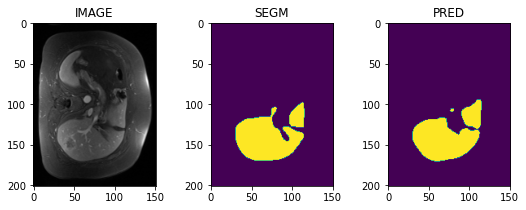

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/LiverHccSeg/TCGA-DD-A4NJ_segm.nii.gz
[0.8211745619773865, 0.9497272968292236, 0.8825232982635498, 0.5928700566291809, 0.9527380466461182, 0.9166718125343323, 0.9392638802528381, 0.9131593704223633, 0.9352486729621887, 0.9263135194778442, 0.9392799735069275, 0.932179868221283, 0.8031650185585022, 0.9144712686538696, 0.5184019804000854, 0.9124687910079956, 0.9098724126815796]


DICE  POST_DICE       HD95  POST_HD95  InferenceTime
count  17.000000  17.000000  17.000000  17.000000      17.000000
mean    0.868208   0.889063  39.823404  10.036882       0.005267
std     0.125220   0.108696  28.782796  15.243517       0.002603
min     0.518402   0.527815   2.236068   2.236068       0.003344
25%     0.882523   0.913159  11.532563   2.828427       0.003545
50%     0.914471   0.926314  50.368641   4.690416       0.004181
75%     0.935249   0.941746  60.386254   5.656854       0.005271
max     0.952738   0.955657  81.436478  62.308907       0.012677

In [47]:
roi_size = (224, 224, 128)

df_LiverHccSeg_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= LiverHccSeg_test_loader, 
        roi_size=roi_size, 
        plot_images=True, 
        save_output=True,
        output_path=OUTPUT_PATH) #, max_eval = 2

torch.cuda.empty_cache()
df_LiverHccSeg_test_results['EXPERIMENT_ID'] = 'LiverHccSeg-PV'
df_LiverHccSeg_test_results.describe()

In [48]:
df_LiverHccSeg_test_results.describe()

DICE  POST_DICE       HD95  POST_HD95  InferenceTime
count  17.000000  17.000000  17.000000  17.000000      17.000000
mean    0.868208   0.889063  39.823404  10.036882       0.005267
std     0.125220   0.108696  28.782796  15.243517       0.002603
min     0.518402   0.527815   2.236068   2.236068       0.003344
25%     0.882523   0.913159  11.532563   2.828427       0.003545
50%     0.914471   0.926314  50.368641   4.690416       0.004181
75%     0.935249   0.941746  60.386254   5.656854       0.005271
max     0.952738   0.955657  81.436478  62.308907       0.012677

In [50]:
df_LiverHccSeg_test_results.to_csv('../LiverHccSegTestingResults/LiverHccSeg-PV.csv')

# External testing

In [35]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import torch
import time


from monai.transforms import KeepLargestConnectedComponent
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice
from monai.metrics import compute_hausdorff_distance
from monai.metrics import compute_average_surface_distance


from monai.data import write_nifti
from tqdm.notebook import tqdm
from monai.data import decollate_batch




def compute_evaluation_metrics(y_pred, y, keep=False):
    
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    hd = monai.metrics.HausdorffDistanceMetric(include_background=False, reduction="mean", percentile=95, get_not_nans=False)
    mad = monai.metrics.SurfaceDistanceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep_largest = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    dice_list = list()
    hd_list = list()
    mad_list = list()
    for y_pred_i, y_i in decollate_batch((y_pred, y)):
        print(y_pred_i.shape)
        print(y_i.shape)
        if keep:
            #dice(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #hd(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            #mad(y_pred=one_hot(keep_largest(argmax(y_pred_i))), y=one_hot(y_i))
            y_pred_i_proc=one_hot(keep_largest(argmax(y_pred_i)))
        else:
                
            # Calculate Dice on the raw output
            #dice(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #hd(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            #mad(y_pred=one_hot(argmax(y_pred_i)), y=one_hot(y_i))
            y_pred_i_proc = one_hot(argmax(y_pred_i))
        y_pred_i_proc = monai.transforms.AddChannel()(y_pred_i_proc)
        y_i_proc = monai.transforms.AddChannel()(one_hot(y_i))
        print(y_pred_i_proc.shape)
            
        #dice(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #hd(y_pred=y_pred_i_proc, y=one_hot(y_i))
        #mad(y_pred=y_pred_i_proc, y=one_hot(y_i))
            
        dice(y_pred=y_pred_i_proc, y=y_i_proc)
        hd(y_pred=y_pred_i_proc, y=y_i_proc)
        mad(y_pred=y_pred_i_proc, y=y_i_proc)
        
        dice_value = dice.aggregate().item()
        hd_value = hd.aggregate().item()
        mad_value = mad.aggregate().item()
        
        print(dice_value)
        print(hd_value)
        print(mad_value)
        
        dice_list.append(dice_value)
        hd_list.append(hd_value)
        mad_list.append(mad_value)
              
    return dice_list, hd_list, mad_list


def run_inference_and_evaluate(model, data_loader, plot_images=False, max_eval=None, 
                               save_output=False,roi_size=(224,224,128), sw_batch_size=4, output_path=None):
    
    """Inference and evaluation function for Liver segmentation.
    
    """   
    
    df_eval = pd.DataFrame()
    
    acc_ids = list()
    input_paths = list()
    output_paths = list()
    
    original_dice_results = list()
    postprocess_dice_results = list()

    original_hd_results = list()
    postprocess_hd_results = list()

    original_mad_results = list()
    postprocess_mad_results = list()
    
    inference_times = list()
    


    
    # Use MONAI one_hot transform
    argmax = monai.transforms.AsDiscrete(argmax=True)
    one_hot = monai.transforms.AsDiscrete(to_onehot=True, n_classes=2)
    dice = monai.metrics.DiceMetric(include_background=False, reduction="mean", get_not_nans=False)
    keep = monai.transforms.KeepLargestConnectedComponent(applied_labels=[1])

    with torch.no_grad():
        for i, test_data in tqdm(enumerate(data_loader)):
        # Early stopping
            if max_eval is not None:
                if i>=max_eval:
                    break

            #print(test_data['ACCESSION_ID'][0])
            #for val in test_data['ACCESSION_ID'][0]:
            #    acc_ids.append(val)

    

            x = test_data['IMAGE'].to(device)
            y = test_data['SEGM'].cpu()

            start_time = time.time()
            y_pred = sliding_window_inference(x, roi_size, sw_batch_size, model)
            stop_time = time.time()

            inference_time = stop_time-start_time
            inference_times.append(inference_time)

            x = x.detach().cpu()
            y_pred = y_pred.detach().cpu()
            #print(y_pred.shape)

            #argmax = torch.argmax(y_pred, dim=1, keepdim=True)
            #argmax = argmax.detach().cpu()

            #y_onehot = one_hot(y)
            #y_pred_onehot = one_hot(argmax)

            # Evaluate segmentation metrics
            eval_list = list()
            # Update to MONAI 0.7+
            dice_values, hd_values, mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y
            )

            for val in dice_values:
                original_dice_results.append(val)
            for val in hd_values:
                original_hd_results.append(val)
            for val in mad_values:
                original_mad_results.append(val)



            post_dice_values, post_hd_values, post_mad_values = compute_evaluation_metrics(
                y_pred=y_pred, y=y, keep=True
            )        #dice_list = list()
            #post_dice_list = list()

            for val in post_dice_values:
                postprocess_dice_results.append(val)
            for val in post_hd_values:
                postprocess_hd_results.append(val)
            for val in post_mad_values:
                postprocess_mad_results.append(val)





            print(y_pred.shape)
            print(argmax(y_pred[0,...]).shape)


            if plot_images:

                slice_num = x.shape[-1]//2

                plt.figure('check', (9, 3))
                plt.subplot(1, 3, 1)
                plt.title('IMAGE')
                plt.imshow(x[0,0,:,:,slice_num], cmap='gray')
 
                plt.subplot(1, 3, 2)
                plt.title('SEGM')
                plt.imshow(y[0,0,:,:,slice_num])

                plt.subplot(1, 3, 3)
                plt.title('PRED')
                #plt.imshow(argmax(y_pred[0,...])[0,:,:,slice_num])
                plt.imshow(keep(argmax(y_pred[0,...]))[0,:,:,slice_num])
                plt.show()


            # Write data out
            if save_output:
                # Get the image affine matrix
                current_affine = test_data['IMAGE_meta_dict']['affine'][0].numpy()
                original_affine = test_data['IMAGE_meta_dict']['original_affine'][0].numpy()
                original_spatial_shape = test_data['IMAGE_meta_dict']['spatial_shape'][0].numpy()

                input_file_name = test_data['IMAGE_meta_dict']['filename_or_obj'][0]
                output_file_name = os.path.split(input_file_name)[1]
                output_root_name = output_file_name[:-len('.nii.gz')]
                
                output_root_name = "ID_" + str(test_data['ACCESSION_ID'][0])
                
                output_path_final = os.path.join(output_path,'{}_segm.nii.gz'.format(output_root_name))
                print('Saving segmentation results: {}'.format(output_path_final))
                
                output_paths.append(output_path_final)
                
                #output_segm = argmax.cpu()[0, 0,...].numpy()
                output_segm = keep(argmax(y_pred[0,...])).cpu()[0,...].numpy()
                write_nifti(output_segm, output_path_final,
                            mode='nearest',
                            affine=current_affine, 
                            target_affine=original_affine,
                            output_spatial_shape=original_spatial_shape, 
                            dtype=np.float32
                           )

    
    #df_eval['ACCESSION_ID'] = acc_ids
    #df_eval['PV'] = input_paths
    df_eval['DICE'] = original_dice_results
    print(original_dice_results)
    df_eval['POST_DICE'] = postprocess_dice_results
    df_eval['HD95'] = original_hd_results
    df_eval['POST_HD95'] = postprocess_hd_results
    #df_eval['MAD'] = original_mad_results
    #df_eval['POST_MAD'] = postprocess_mad_results
    df_eval['InferenceTime'] = inference_times
    if output_path is not None:
        df_eval['AUTOMATED-LIVER-SEGM'] = output_paths    
    return df_eval


In [37]:
import glob 
import pandas as pd

external_testing_img_paths = pd.read_csv('/tensor5/data1/jonofrey/Liver/Paris/registration/nonrigid_nmi/Nonrigid_Registered_NMI_Image_Paths.csv')

included_accs = [1,3, 4, 6, 10, 11, 12, 17, 18, 19, 22, 32, 35, 40, 55, 59]
external_testing_img_paths = external_testing_img_paths[external_testing_img_paths['ACCESSION_ID'].isin(included_accs)]

segm_path = '/tensor5/data1/mgross/Liver/Paris/man_liver_segms/*_PV_LIVER-label.nii.gz'
segm_paths = glob.glob(segm_path)

external_testing_accs = [int(i.split('/')[-1].split('_')[0]) for i in segm_paths]

df_external_testing = pd.DataFrame({'ACCESSION_ID': external_testing_accs, 'SEGM' : segm_paths})
df_external_testing = pd.merge(external_testing_img_paths, df_external_testing, on = 'ACCESSION_ID')

df_external_testing = df_external_testing[['ACCESSION_ID','PV_PRE','PV_ART','PV','PV_DEL',  'SEGM']]



df_external_testing.rename(columns={'PV' : 'IMAGE', 'LIVER': 'SEGM'}, inplace = True)
df_external_testing

ACCESSION_ID                                             PV_PRE  \
0              1  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
1              3  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
2              4  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
3              6  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
4             10  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
5             11  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
6             12  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
7             17  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
8             18  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
9             19  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
10            22  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
11            32  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
12            35  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
13            40  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
14            55  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
15            59  /tensor5/data1/jonofrey/Liver/Paris/registrati...   

                                               PV_ART  \
0   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
1   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
2   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
3   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
4   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
5   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
6   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
7   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
8   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
9   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
10  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
11  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
12  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
13  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
14  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
15  /tensor5/data1/jonofrey/Liver/Paris/registrati...   

                                                IMAGE  \
0   /tensor5/data1/mgross/Liver/Paris/00001/00001_...   
1   /tensor5/data1/mgross/Liver/Paris/00003/00003_...   
2   /tensor5/data1/mgross/Liver/Paris/00004/00004_...   
3   /tensor5/data1/mgross/Liver/Paris/00006/00006_...   
4   /tensor5/data1/mgross/Liver/Paris/00010/00010_...   
5   /tensor5/data1/mgross/Liver/Paris/00011/00011_...   
6   /tensor5/data1/mgross/Liver/Paris/00012/00012_...   
7   /tensor5/data1/mgross/Liver/Paris/00017/00017_...   
8   /tensor5/data1/mgross/Liver/Paris/00018/00018_...   
9   /tensor5/data1/mgross/Liver/Paris/00019/00019_...   
10  /tensor5/data1/mgross/Liver/Paris/00022/00022_...   
11  /tensor5/data1/mgross/Liver/Paris/00032/00032_...   
12  /tensor5/data1/mgross/Liver/Paris/00035/00035_...   
13  /tensor5/data1/mgross/Liver/Paris/00040/00040_...   
14  /tensor5/data1/mgross/Liver/Paris/00055/00055_...   
15  /tensor5/data1/mgross/Liver/Paris/00059/00059_...   

                                               PV_DEL  \
0   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
1   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
2   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
3   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
4   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
5   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
6   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
7   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
8   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
9   /tensor5/data1/jonofrey/Liver/Paris/registrati...   
10  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
11  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
12  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
13  /tensor5/data1/jonofrey/Liver/Paris/registrati...   
1

In [38]:
external_test_data_dict = df_external_testing.to_dict('records')
print('Number of external testing files: ', len(external_test_data_dict))

Number of external testing files:  16


In [39]:
external_test_ds = monai.data.PersistentDataset(
    data=external_test_data_dict, transform=test_transforms, cache_dir=CACHE_PATH
)

external_test_loader = DataLoader(external_test_ds, batch_size=1, num_workers=4)

In [40]:
OUTPUT_PATH = r'/tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/PARIS'

torch.Size([1, 1, 230, 230, 125])
image shape: torch.Size([230, 230, 125]), label shape: torch.Size([230, 230, 125])
image mean: 0.4182465672492981


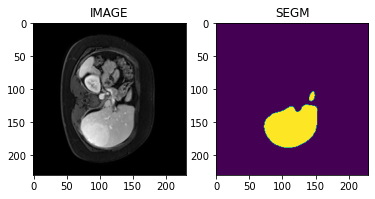

In [43]:
check_ds = monai.data.Dataset(data=external_test_data_dict[1:2], transform=test_transforms)

check_loader = DataLoader(check_ds, batch_size=1, num_workers=0, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data['IMAGE'].shape)

num_display = 10
if check_data['IMAGE'].shape[0] < num_display:
    num_display = check_data['IMAGE'].shape[0]

for i in range(num_display):
    image, label = (check_data['IMAGE'][i][0], check_data['SEGM'][i][0])
    print('image shape: {}, label shape: {}'.format(image.shape, label.shape))
    print('image mean: {}'.format(np.mean(image.numpy())))

    slice_num = image.shape[2]//2
    
    plt.figure('check', (6, 3))
    plt.subplot(1, 2, 1)
    plt.title('IMAGE')
    plt.imshow(image[:,:,slice_num], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('SEGM')
    plt.imshow(label[:,:,slice_num])
    plt.show()

0it [00:00, ?it/s]

torch.Size([2, 210, 210, 100])
torch.Size([1, 210, 210, 100])
torch.Size([1, 2, 210, 210, 100])
0.9659273028373718
3.0
2.4753004700962373
torch.Size([2, 210, 210, 100])
torch.Size([1, 210, 210, 100])
torch.Size([1, 2, 210, 210, 100])
0.9685832262039185
2.23606797749979
0.4942022894679211
torch.Size([1, 2, 210, 210, 100])
torch.Size([1, 210, 210, 100])


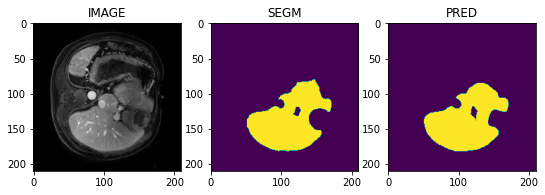

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/PARIS/ID_tensor(1)_segm.nii.gz
torch.Size([2, 230, 230, 125])
torch.Size([1, 230, 230, 125])
torch.Size([1, 2, 230, 230, 125])
0.9750691652297974
3.0
0.47339518140989695
torch.Size([2, 230, 230, 125])
torch.Size([1, 230, 230, 125])
torch.Size([1, 2, 230, 230, 125])
0.9750691652297974
3.0
0.47339518140989695
torch.Size([1, 2, 230, 230, 125])
torch.Size([1, 230, 230, 125])


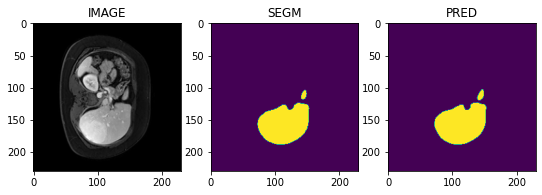

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/PARIS/ID_tensor(3)_segm.nii.gz
torch.Size([2, 228, 228, 105])
torch.Size([1, 228, 228, 105])
torch.Size([1, 2, 228, 228, 105])
0.9360441565513611
40.822174891488615
4.205766594838223
torch.Size([2, 228, 228, 105])
torch.Size([1, 228, 228, 105])
torch.Size([1, 2, 228, 228, 105])
0.9432206749916077
2.23606797749979
1.0774268772802176
torch.Size([1, 2, 228, 228, 105])
torch.Size([1, 228, 228, 105])


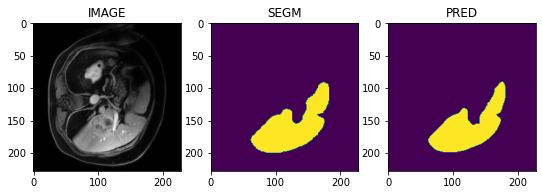

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/PARIS/ID_tensor(4)_segm.nii.gz
torch.Size([2, 211, 211, 104])
torch.Size([1, 211, 211, 104])
torch.Size([1, 2, 211, 211, 104])
0.973178505897522
1.7320508075688772
1.120484020400707
torch.Size([2, 211, 211, 104])
torch.Size([1, 211, 211, 104])
torch.Size([1, 2, 211, 211, 104])
0.9747050404548645
1.7320508075688772
0.422126402356192
torch.Size([1, 2, 211, 211, 104])
torch.Size([1, 211, 211, 104])


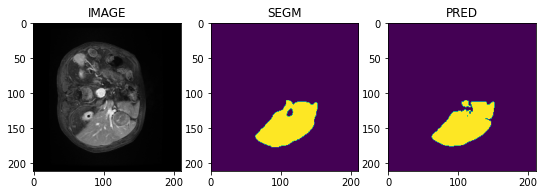

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/PARIS/ID_tensor(6)_segm.nii.gz
torch.Size([2, 191, 167, 118])
torch.Size([1, 191, 167, 118])
torch.Size([1, 2, 191, 167, 118])
0.9418985843658447
64.17164482853778
15.821534403436333
torch.Size([2, 191, 167, 118])
torch.Size([1, 191, 167, 118])
torch.Size([1, 2, 191, 167, 118])
0.9596234560012817
3.0
0.5562588516489937
torch.Size([1, 2, 191, 167, 118])
torch.Size([1, 191, 167, 118])


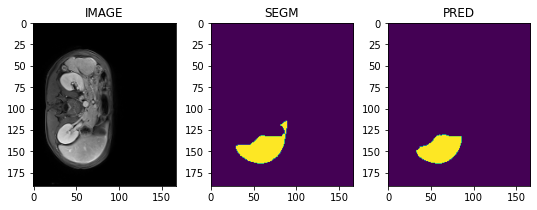

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/PARIS/ID_tensor(10)_segm.nii.gz
torch.Size([2, 211, 211, 109])
torch.Size([1, 211, 211, 109])
torch.Size([1, 2, 211, 211, 109])
0.9732263088226318
2.23606797749979
0.5199142328051898
torch.Size([2, 211, 211, 109])
torch.Size([1, 211, 211, 109])
torch.Size([1, 2, 211, 211, 109])
0.9732508063316345
2.23606797749979
0.48518813135001415
torch.Size([1, 2, 211, 211, 109])
torch.Size([1, 211, 211, 109])


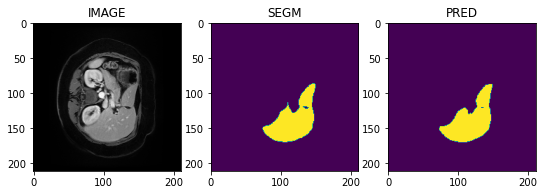

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/PARIS/ID_tensor(11)_segm.nii.gz
torch.Size([2, 201, 178, 108])
torch.Size([1, 201, 178, 108])
torch.Size([1, 2, 201, 178, 108])
0.959286093711853
3.7416573867739413
2.157720663287572
torch.Size([2, 201, 178, 108])
torch.Size([1, 201, 178, 108])
torch.Size([1, 2, 201, 178, 108])
0.9620543718338013
3.7416573867739413
0.5970295353752058
torch.Size([1, 2, 201, 178, 108])
torch.Size([1, 201, 178, 108])


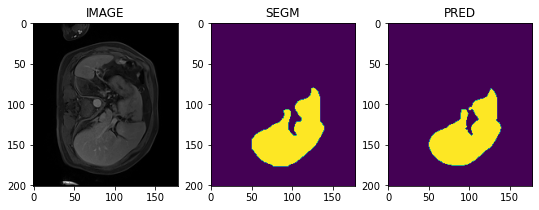

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/PARIS/ID_tensor(12)_segm.nii.gz
torch.Size([2, 204, 204, 100])
torch.Size([1, 204, 204, 100])
torch.Size([1, 2, 204, 204, 100])
0.9403901100158691
4.242640687119285
2.062107652460227
torch.Size([2, 204, 204, 100])
torch.Size([1, 204, 204, 100])
torch.Size([1, 2, 204, 204, 100])
0.9411832094192505
4.242640687119285
0.933428846871128
torch.Size([1, 2, 204, 204, 100])
torch.Size([1, 204, 204, 100])


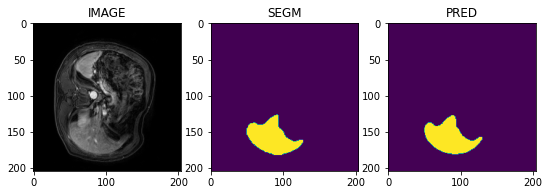

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/PARIS/ID_tensor(17)_segm.nii.gz
torch.Size([2, 189, 189, 105])
torch.Size([1, 189, 189, 105])
torch.Size([1, 2, 189, 189, 105])
0.9601733088493347
3.1622776601683795
1.3146102392857213
torch.Size([2, 189, 189, 105])
torch.Size([1, 189, 189, 105])
torch.Size([1, 2, 189, 189, 105])
0.9609504342079163
3.1622776601683795
0.5705421672818857
torch.Size([1, 2, 189, 189, 105])
torch.Size([1, 189, 189, 105])


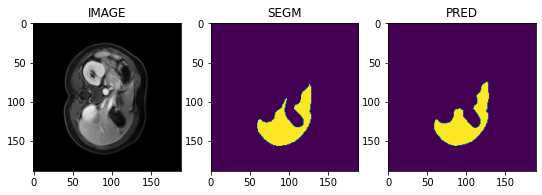

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/PARIS/ID_tensor(18)_segm.nii.gz
torch.Size([2, 201, 201, 96])
torch.Size([1, 201, 201, 96])
torch.Size([1, 2, 201, 201, 96])
0.9735274910926819
2.0
0.9639589120148386
torch.Size([2, 201, 201, 96])
torch.Size([1, 201, 201, 96])
torch.Size([1, 2, 201, 201, 96])
0.9739785194396973
2.0
0.4149371693291303
torch.Size([1, 2, 201, 201, 96])
torch.Size([1, 201, 201, 96])


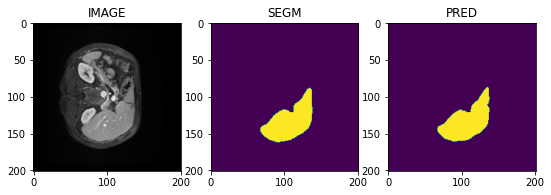

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/PARIS/ID_tensor(19)_segm.nii.gz
torch.Size([2, 210, 210, 100])
torch.Size([1, 210, 210, 100])
torch.Size([1, 2, 210, 210, 100])
0.9645662307739258
2.23606797749979
1.4457920690307746
torch.Size([2, 210, 210, 100])
torch.Size([1, 210, 210, 100])
torch.Size([1, 2, 210, 210, 100])
0.9652196168899536
2.23606797749979
0.5678990948594291
torch.Size([1, 2, 210, 210, 100])
torch.Size([1, 210, 210, 100])


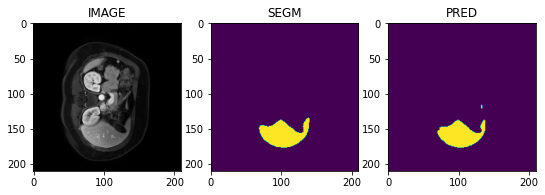

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/PARIS/ID_tensor(22)_segm.nii.gz
torch.Size([2, 210, 210, 110])
torch.Size([1, 210, 210, 110])
torch.Size([1, 2, 210, 210, 110])
0.9517894983291626
105.88814843838396
25.280779970886964
torch.Size([2, 210, 210, 110])
torch.Size([1, 210, 210, 110])
torch.Size([1, 2, 210, 210, 110])
0.9751808643341064
1.4142135623730951
0.47147091751970716
torch.Size([1, 2, 210, 210, 110])
torch.Size([1, 210, 210, 110])


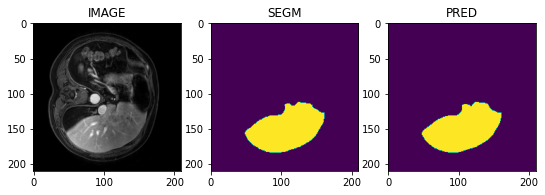

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/PARIS/ID_tensor(32)_segm.nii.gz
torch.Size([2, 210, 210, 125])
torch.Size([1, 210, 210, 125])
torch.Size([1, 2, 210, 210, 125])
0.8306410312652588
19.79898987322333
4.266346049539149
torch.Size([2, 210, 210, 125])
torch.Size([1, 210, 210, 125])
torch.Size([1, 2, 210, 210, 125])
0.8306410312652588
19.79898987322333
4.266346049539149
torch.Size([1, 2, 210, 210, 125])
torch.Size([1, 210, 210, 125])


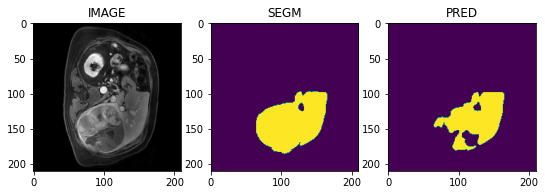

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/PARIS/ID_tensor(35)_segm.nii.gz
torch.Size([2, 172, 172, 100])
torch.Size([1, 172, 172, 100])
torch.Size([1, 2, 172, 172, 100])
0.9548922181129456
4.123105625617661
1.1077629881245354
torch.Size([2, 172, 172, 100])
torch.Size([1, 172, 172, 100])
torch.Size([1, 2, 172, 172, 100])
0.9552941918373108
4.123105625617661
0.6429076211746111
torch.Size([1, 2, 172, 172, 100])
torch.Size([1, 172, 172, 100])


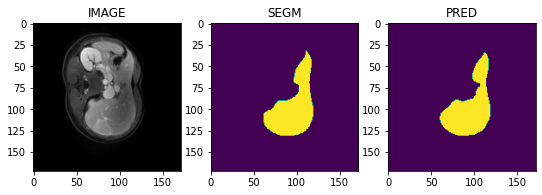

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/PARIS/ID_tensor(40)_segm.nii.gz
torch.Size([2, 221, 221, 114])
torch.Size([1, 221, 221, 114])
torch.Size([1, 2, 221, 221, 114])
0.9767232537269592
2.0
0.8902224299606303
torch.Size([2, 221, 221, 114])
torch.Size([1, 221, 221, 114])
torch.Size([1, 2, 221, 221, 114])
0.9769949316978455
2.0
0.4671643584216023
torch.Size([1, 2, 221, 221, 114])
torch.Size([1, 221, 221, 114])


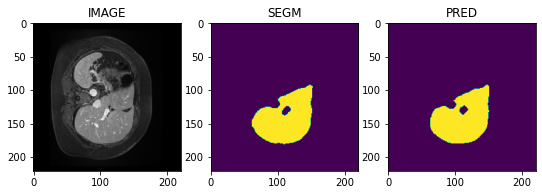

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/PARIS/ID_tensor(55)_segm.nii.gz
torch.Size([2, 207, 207, 105])
torch.Size([1, 207, 207, 105])
torch.Size([1, 2, 207, 207, 105])
0.9658036828041077
2.23606797749979
1.5933137659013874
torch.Size([2, 207, 207, 105])
torch.Size([1, 207, 207, 105])
torch.Size([1, 2, 207, 207, 105])
0.9665895700454712
2.23606797749979
0.5675133028611091
torch.Size([1, 2, 207, 207, 105])
torch.Size([1, 207, 207, 105])


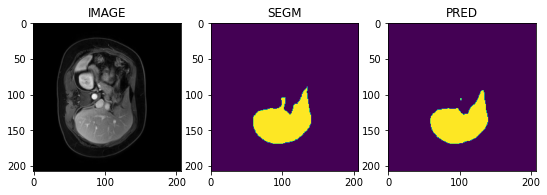

Saving segmentation results: /tensor5/data1/mgross/Liver/studies/Contrast-Nets/PV-NET/PARIS/ID_tensor(59)_segm.nii.gz
[0.9659273028373718, 0.9750691652297974, 0.9360441565513611, 0.973178505897522, 0.9418985843658447, 0.9732263088226318, 0.959286093711853, 0.9403901100158691, 0.9601733088493347, 0.9735274910926819, 0.9645662307739258, 0.9517894983291626, 0.8306410312652588, 0.9548922181129456, 0.9767232537269592, 0.9658036828041077]


DICE  POST_DICE        HD95  POST_HD95  InferenceTime
count  16.000000  16.000000   16.000000  16.000000      16.000000
mean    0.952696   0.956409   16.524431   3.712205       0.005667
std     0.035013   0.035278   29.577966   4.370451       0.001790
min     0.830641   0.830641    1.732051   1.414214       0.003687
25%     0.949317   0.958541    2.236068   2.177051       0.004390
50%     0.962370   0.965905    3.081139   2.236068       0.004694
75%     0.973190   0.974160    8.131728   3.307123       0.007051
max     0.976723   0.976995  105.888148  19.798990       0.009675

In [45]:
roi_size = (224, 224, 128)

df_external_test_results = run_inference_and_evaluate(
        model=model, 
        data_loader= external_test_loader, 
        roi_size=roi_size, 
        plot_images=True, 
        save_output=True,
        output_path= OUTPUT_PATH) #, max_eval = 2

torch.cuda.empty_cache()
df_external_test_results['EXPERIMENT_ID'] = 'PV-Contrast-Imaging'
df_external_test_results.describe()

In [49]:
df_external_test_results.to_csv('../ExternalTestingResults/Results-PV-Net.csv')